# **SmartSeq MCF7 Cell Line: ```metadata``` and ```unfiltered``` data**

-----



In this file we will analyze the ```metadata``` and ```unfiltered``` datasets for the MCF7 cell line with the SmartSeq technique. Since the majority of the explanations have been already done in the HCC1806 files, we'll keep the comments as short as possible to avoid being repetitive.

The structure of the file will be similar to before:

- Python Libraries
- Exploratory Data Analysis
  - Metadata
  - Unfiltered
    - Introductory Information
    - Sparsity
    - Outliers
    - Distributions
    - Correlation
- Data Preprocessing
  - Quality Control (QC)
    - QC for Cells
    - QC for Genes
  - Normalization and Scaling
  - A Note on Cell Cycles
  - Feature Selection
  - Dimensionality Reduction
    - PCA
    - t-SNE
    - UMAP
- Downstream Analysis
  - Correlation
  - Unsupervised Clustering
    - Hierarchical
    - K-Means
    - Leiden Clustering Technique
  - Gene Annotation

With the final dataset we get, we'll then run the classification on a separate file.

# **Python Libraries**

In [6]:
# install additional packages
!pip install -q scanpy
!pip install -q scikit-misc
!pip install -q pyvis
!pip install -q leidenalg

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import random
from scipy.stats import kurtosis, skew
from scipy.cluster.hierarchy import dendrogram, linkage
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
import umap.umap_ as umap
import networkx as nx
from pyvis.network import Network
from sklearn.cluster import KMeans

np.random.seed(42)

assert pd.__version__ <= "1.5.3" # some cells will NOT run in the new 2.0 version!

In [8]:
# code used to avoid having long (and useless) warning messages
import warnings
warnings.filterwarnings("ignore", message="No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored")
warnings.filterwarnings("ignore", message="The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning")

In [9]:
# MCF7 cell line data paths
path_m_metadata = "./SmartSeq/MCF7_SmartS_MetaData.tsv"
path_m_unfiltered = "./SmartSeq/MCF7_SmartS_Unfiltered_Data.txt"
path_m_filtered = "./SmartSeq/MCF7_SmartS_Filtered_Data.txt"
path_m_filtered_norm_train = "./SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt"
path_m_filtered_norm_test = "./SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt"

# **Exploratory Data Analysis**

In this section we'll explore the data.

## Metadata

Let's check the metadata file.

In [10]:
#Loading the file 
m_metadata = pd.read_csv(path_m_metadata, sep="\t")

In [11]:
#Dimension and view of the dataframe
print("Dataframe dimension:", m_metadata.shape)
m_metadata.head()

Dataframe dimension: (383, 9)


Filename Cell Line           Lane  \
0  output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...      MCF7  output.STAR.1   
1  output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...      MCF7  output.STAR.1   
2  output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...      MCF7  output.STAR.1   
3  output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...      MCF7  output.STAR.1   
4  output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...      MCF7  output.STAR.1   

   Pos Condition  Hours Cell name               PreprocessingTag  \
0  A10      Hypo     72       S28  Aligned.sortedByCoord.out.bam   
1  A11      Hypo     72       S29  Aligned.sortedByCoord.out.bam   
2  A12      Hypo     72       S30  Aligned.sortedByCoord.out.bam   
3   A1      Norm     72        S1  Aligned.sortedByCoord.out.bam   
4   A2      Norm     72        S2  Aligned.sortedByCoord.out.bam   

   ProcessingComments  
0  STAR,FeatureCounts  
1  STAR,FeatureCounts  
2  STAR,FeatureCounts  
3  STAR,FeatureCounts  
4  STAR,FeatureCounts

In [12]:
#general informations about the dataframe
m_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383 entries, 0 to 382
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Filename            383 non-null    object
 1   Cell Line           383 non-null    object
 2   Lane                383 non-null    object
 3   Pos                 383 non-null    object
 4   Condition           383 non-null    object
 5   Hours               383 non-null    int64 
 6   Cell name           383 non-null    object
 7   PreprocessingTag    383 non-null    object
 8   ProcessingComments  383 non-null    object
dtypes: int64(1), object(8)
memory usage: 27.1+ KB


Now we have 383 cells. 

In [13]:
#For each column, which are the possible values
print("Filename length: ", len(m_metadata["Filename"].unique()))
print("Cell line[{}]: {}".format(len(m_metadata["Cell Line"].unique()), m_metadata["Cell Line"].unique()))
# print("PCR Plate[{}]: {}".format(len(m_metadata[""].unique()), m_metadata["PCR Plate"].unique()))
print("Pos[{}]: {}".format(len(m_metadata["Pos"].unique()), m_metadata["Pos"].unique()))
print("Condition[{}]: {}".format(len(m_metadata["Condition"].unique()), m_metadata["Condition"].unique()))
print("Hours[{}]: {}".format(len(m_metadata["Hours"].unique()), m_metadata["Hours"].unique()))
print("Cell name[{}]: {}".format(len(m_metadata["Cell name"].unique()), m_metadata["Cell name"].unique()))
print("Preprocessing tags[{}]: {}".format(len(m_metadata["PreprocessingTag"].unique()), m_metadata["PreprocessingTag"].unique()))
print("Processing comments[{}]: {}".format(len(m_metadata["ProcessingComments"].unique()), m_metadata["ProcessingComments"].unique()))

Filename length:  383
Cell line[1]: ['MCF7']
Pos[98]: ['A10' 'A11' 'A12' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'A8' 'A9' 'B10'
 'B11' 'B12' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'B8' 'B9' 'C10' 'C11'
 'C12' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'C9' 'D10' 'D11' 'D12' 'D1'
 'D2' 'D3' 'D4' 'D5' 'D6' 'D7' 'D8' 'D9' 'E10' 'E11' 'E12' 'E1' 'E2' 'E3'
 'E4' 'E5' 'E6' 'E7' 'E8' 'E9' 'F10' 'F11' 'F12' 'F1' 'F2' 'F3' 'F4' 'F5'
 'F6' 'F7' 'F8' 'F9' 'G10' 'G11' 'G12' 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7'
 'G8' 'G9' 'H10' 'H11' 'H12' 'H1' 'H2' 'H3' 'H4' 'H5' 'H6' 'H7' 'H8' 'H9'
 'H13' 'H14']
Condition[2]: ['Hypo' 'Norm']
Hours[1]: [72]
Cell name[383]: ['S28' 'S29' 'S30' 'S1' 'S2' 'S3' 'S4' 'S5' 'S6' 'S25' 'S26' 'S27' 'S76'
 'S77' 'S78' 'S49' 'S50' 'S51' 'S52' 'S53' 'S54' 'S73' 'S74' 'S75' 'S124'
 'S125' 'S126' 'S97' 'S98' 'S99' 'S100' 'S101' 'S102' 'S121' 'S122' 'S123'
 'S172' 'S173' 'S174' 'S145' 'S146' 'S147' 'S148' 'S149' 'S150' 'S169'
 'S170' 'S171' 'S220' 'S221' 'S222' 'S193' 'S194' 'S195' 'S196' 'S1

Again we get the same information as before, with the only difference being that we are not given data on the PCR plate used, so probably only one was used.
Let's check the proportions of hypoxic and normoxic cells.

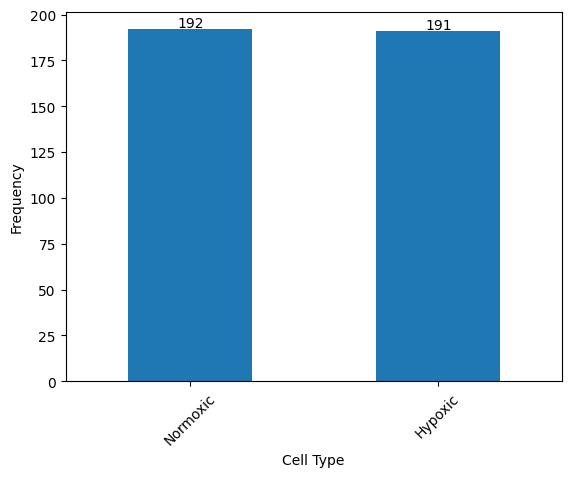

In [14]:
normoxic_cells = m_metadata["Filename"].str.contains('Norm').sum()
hypoxic_cells = m_metadata["Filename"].str.contains('Hypo').sum()
s = pd.Series({"Normoxic" : normoxic_cells, "Hypoxic" : hypoxic_cells})
s.plot.bar(rot = 45)
plt.text(-0.05, 193, str(normoxic_cells))
plt.text(0.95, 192, str(hypoxic_cells))
plt.xlabel("Cell Type")
plt.ylabel("Frequency")
plt.grid(False)
plt.show()

No group is overrepresented.

## Unfiltered

### Introductory Information

In [15]:
#Loading MCF7_SmartS_Unfiltered_Data.txt
m_unfiltered = pd.read_csv(path_m_unfiltered, sep = " ")

In [16]:
#General informations about the file
m_unfiltered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22934 entries, WASH7P to MAFIP
Columns: 383 entries, output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam to output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam
dtypes: int64(383)
memory usage: 67.2+ MB


In [17]:
#Dimensions of the dataframe
m_unfiltered.shape

(22934, 383)

In [18]:
#which are the indexes, which are the columns
print("Dataframe indexes: ", m_unfiltered.index)
print("Dataframe columns: ", m_unfiltered.columns)

Dataframe indexes:  Index(['WASH7P', 'MIR6859-1', 'WASH9P', 'OR4F29', 'MTND1P23', 'MTND2P28',
       'MTCO1P12', 'MTCO2P12', 'MTATP8P1', 'MTATP6P1',
       ...
       'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB',
       'MT-TT', 'MT-TP', 'MAFIP'],
      dtype='object', length=22934)
Dataframe columns:  Index(['output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam',
       'output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam',
       ...
      

In [19]:
#check the type of the columns
m_unfiltered.dtypes.unique() 

array([dtype('int64')], dtype=object)

In [20]:
#view of the dataframe
m_unfiltered.head()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     1          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          

           output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                    10        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        

           output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam  ...  \
WASH7P                                                     0        ...   
MIR6859-1                                                  0        ...   
WASH9P         

In this gene expression matrix, we have 383 sample cells and 22934 genes.
Now let's try to understand the structure of our dataset. 


### Sparsity

We'll explore basic structures and delve into the sparsity since that's what matters the most now.

In [21]:
#number of missing values
m_unfiltered.isna().sum().sum()

0

Notice that we have no missing values.

In [22]:
#general statistics of the dataframe
m_unfiltered.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           40.817651          
std                                           465.709940          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            17.000000          
max                                         46744.000000          

       output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                            0.012253          
std                                             0.207726          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                            14.000000          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000          
mean                                           86.442400          
std                                          1036.572689          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             5.000000          
max                                         82047.000000          

       output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                            1.024636        
std                                             6.097362        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             0.000000        
max                                           289.000000        

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           14.531351        
std                                           123.800530        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             7.000000        
max                                         10582.000000        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           56.213613        
std                                           503.599145        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            23.000000        
max                                         46856.000000        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                       22934.000000        
mean                                           75.397183        
std                                           430.471519        
min                                             0.000000        
25%                                             0.000000        
50%                                            

In [23]:
#average number of genes expressed, average number of cell expressing
m_unfiltered_entries1 = m_unfiltered.copy().astype(bool).astype(int)
print("Average expressed genes by each cell: ", np.count_nonzero(m_unfiltered_entries1, axis=0).mean().round(3))
print("Average expressing cells for each gene: ", np.count_nonzero(m_unfiltered_entries1, axis=1).mean().round(3))

Average expressed genes by each cell:  9124.219
Average expressing cells for each gene:  152.375


Let's have a look at the median:

In [24]:
#average value of the median
print(f"Average median across all cells: {m_unfiltered.describe().loc['50%'].mean():.3f}")

#number of cells and percentage of cells with 0 median
filt = m_unfiltered.describe().loc['50%'] == 0
number_cell_0_median = m_unfiltered.describe().loc['50%', filt].count() #counts the number of cells with 0 median
print("Number of cells with 0 median: {}, Percentage: {:.3f}".format(number_cell_0_median, number_cell_0_median / m_unfiltered.shape[1]))

Average median across all cells: 0.099
Number of cells with 0 median: 348, Percentage: 0.909


We get similar patterns to the other cell line. Indeed each cells expressed 9000 genes on average, and each gene is expressed by 150 cells on average.
Moreover, once again the matrix is surely sparse as 90% of the cells have zero median. 

Let's calculate the sparsity index and plot the sparsity

In [25]:
#computing this sparsity index
sparsity_index_unfiltered = 1 - (np.count_nonzero(m_unfiltered.values) / m_unfiltered.size)
sparsity_index_unfiltered

0.6021531646834907

Compared to the other cell line with sparsity 0.56, now it is higher at 0.60

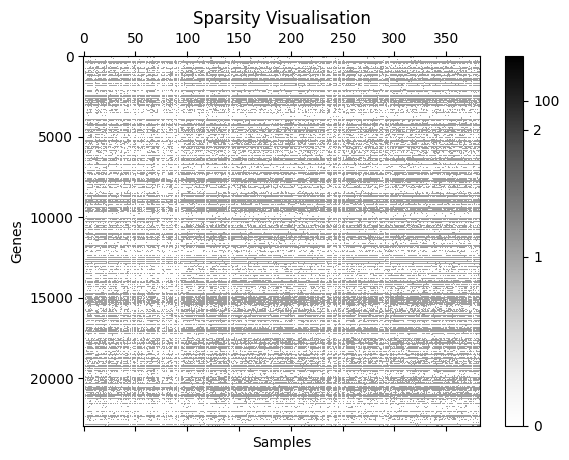

In [26]:
#sparsity visualisation
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.8, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.8, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)


fig, ax = plt.subplots()
midnorm = MidpointNormalize(vmin=0, vcenter=1.75, vmax=250)

graph_temporary = plt.spy(m_unfiltered, aspect = "auto", norm=midnorm,
                   cmap='Greys') #hsv
plt.colorbar(graph_temporary).set_ticks([0, 1, 2, 100])
plt.grid(False)
plt.xlabel("Samples")
plt.ylabel("Genes")
ax.set_title('Sparsity Visualisation')

plt.show()

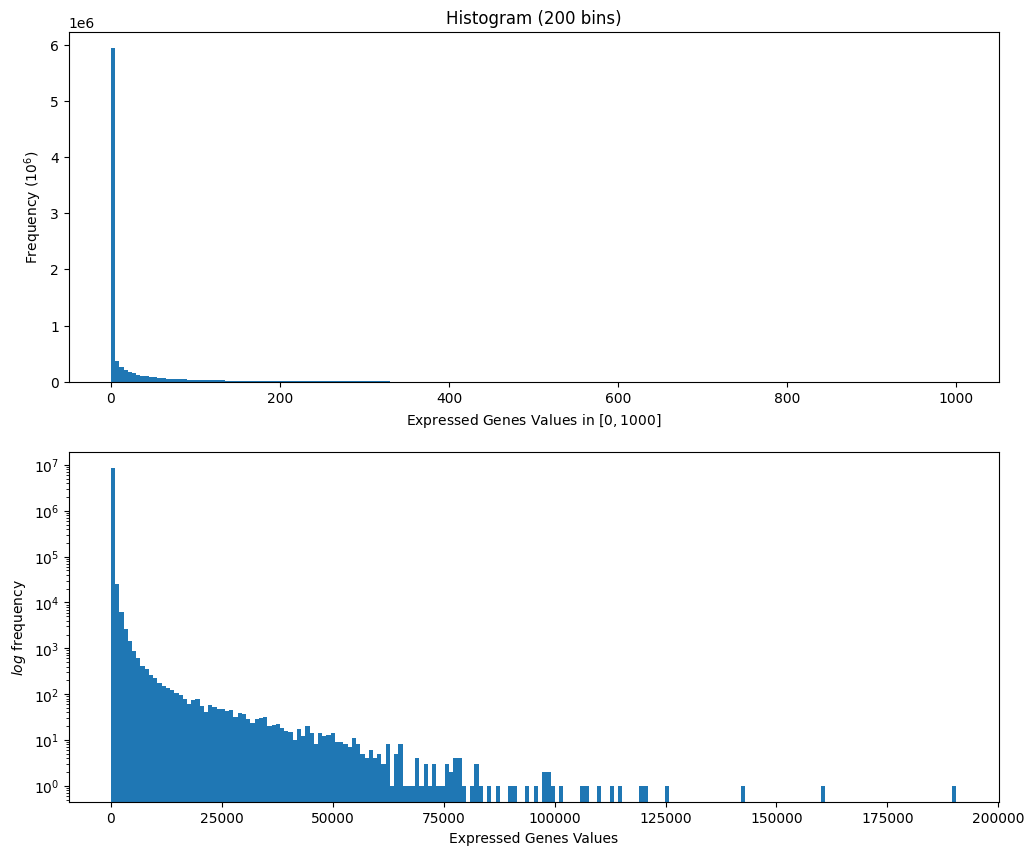

In [27]:
#distribution of the whole matrix
m_unfiltered_flattened = pd.Series(m_unfiltered.values.flatten())
fig, ax = plt.subplots(2, 1, figsize=(12, 10)) 
ax[0].hist(m_unfiltered_flattened, range = [0, 1000], bins = 200)
ax[0].set_xlabel("Expressed Genes Values in $[0, 1000]$")
ax[0].set_ylabel("Frequency ($10^6$)")
ax[0].set_title("Histogram (200 bins)")
m_unfiltered_flattened = m_unfiltered_flattened
ax[1].hist(m_unfiltered_flattened, bins = 200, log = True)
ax[1].set_xlabel("Expressed Genes Values")
ax[1].set_ylabel("$log$ frequency")
plt.show()

The plots show that most values are 0 and they decreases sort of exponentially fast, like in the HCC1806 cell line.

In [28]:
#check other location metrics
round(m_unfiltered_flattened.describe())

count    8783722.0
mean          43.0
std          510.0
min            0.0
25%            0.0
50%            0.0
75%           15.0
max       190556.0
dtype: float64

In [29]:
#skewness and kurtosis of the whole matrix
skew_matrix = skew(m_unfiltered_flattened)
kurtosis_matrix = kurtosis(m_unfiltered_flattened)
print("Skewness of the whole matrix: ", round(skew_matrix))
print("Kurtosis of the whole matrix: ", round(kurtosis_matrix))

Skewness of the whole matrix:  92
Kurtosis of the whole matrix:  13978


Skewness and kurtosis are high, indicating a highly non-normal distribution, so non symmetric and with long and skinny tails.

In [30]:
#proportion of genes that are not expressed and proportion of cells that are not expressing 
expressed_genes = 1 - (np.count_nonzero(m_unfiltered.sum(axis = 1)) / m_unfiltered.shape[0])
expressing_cells = 1 - (np.count_nonzero(m_unfiltered.sum(axis = 0)) / m_unfiltered.shape[1])
print("Expressed genes:", expressed_genes, "\nExpressing cells: ", expressing_cells)

Expressed genes: 0.0 
Expressing cells:  0.0


All cells codify at least one gene, and all genes are codified by at least one cell.

In [31]:
# which is the gene that is expressed less
min_expressed_gene = m_unfiltered.sum(axis = 1).idxmin()
print("Least expressed gene: {}\nNumber of codifying samples: {}".format(min_expressed_gene, m_unfiltered.sum(axis = 1)[min_expressed_gene]))

# which is the gene that is expressed most
max_expressed_gene = m_unfiltered.sum(axis = 1).idxmax()
print("\nMost expressed gene: {}\nNumber of codifying samples: {}".format(max_expressed_gene, m_unfiltered.sum(axis = 1)[max_expressed_gene]))

#which is the cell that expresses less (cell: how many it produces, which uniques)
min_expressed_gene = m_unfiltered.sum(axis = 0).idxmin()
print("\nLeast expressed cell: {}\nProduced genes:{}\nUnique genes:{}\n".format(min_expressed_gene, m_unfiltered.sum(axis = 0)[min_expressed_gene], m_unfiltered.astype(bool).sum(axis = 0).min()))

#which is the cell that expresses most (cell: how many it produces, which uniques)
max_expressed_gene = m_unfiltered.sum(axis = 0).idxmax()
print("Most expressed cell: {}\nProduced genes:{}\nUnique genes:{}".format(max_expressed_gene, m_unfiltered.sum(axis = 0)[max_expressed_gene], m_unfiltered.astype(bool).sum(axis = 0).max()))

Least expressed gene: CICP3
Number of codifying samples: 2

Most expressed gene: KRT8
Number of codifying samples: 8829208

Least expressed cell: output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam
Produced genes:1
Unique genes:1

Most expressed cell: output.STAR.2_C7_Hypo_S127_Aligned.sortedByCoord.out.bam
Produced genes:2308057
Unique genes:12519


In [32]:
#which gene are produced the most by each cell
print(pd.DataFrame({'gene': m_unfiltered.idxmax(), 'value': m_unfiltered.max()}))
print("Uniques[{}]: {}".format(m_unfiltered.idxmax().unique().size, m_unfiltered.idxmax().unique()))

                                                       gene  value
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...     ACTB  46744
output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoor...  SLC6A14     14
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...    ACTG1  82047
output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord....     ACTB    289
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....    KRT18  10582
...                                                     ...    ...
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...     KRT8  19285
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...    GAPDH  28021
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...   CYP1B1  40708
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...     ACTB  46261
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...    GAPDH  68790

[383 rows x 2 columns]
Uniques[23]: ['ACTB' 'SLC6A14' 'ACTG1' 'KRT18' 'KRT8' 'GAPDH' 'ALDOA' 'DOT1L' 'CYP1A1'
 'CYP1B1' 'SORT1' 'MALAT1' 'TBCB' 'EML6' 'TFF1' 'KRT19' 'EXTL3-AS1'
 'COL6A3' 'COX6C'

Above we see which genes are the most codified and some interesting statistics about the cells and genes.

Now let's check if there are some differences when dealing with normoxia / hypoxia cells.



In [33]:
#define dataframe with normoxic, hypoxic cells
normoxic_cells = m_unfiltered.columns.str.contains('Norm')
hypoxic_cells = m_unfiltered.columns.str.contains('Hypo')
norm_hypo_cells = pd.Series({"Normoxic" : normoxic_cells, "Hypoxic" : hypoxic_cells})

In [34]:
#values of nonzero for normoxic, hypoxic cells
codified_genes_normoxia = np.count_nonzero(m_unfiltered.loc[:, normoxic_cells].values)
codified_genes_hypoxia = np.count_nonzero(m_unfiltered.loc[:, hypoxic_cells].values)
print("Codified genes in normoxic cells: ", codified_genes_normoxia)
print("Codified genes in hypoxic cells: ", codified_genes_hypoxia)

Codified genes in normoxic cells:  1899782
Codified genes in hypoxic cells:  1594794


They both codify for roughly the same amount of genes. Let's check how, with the distributions.

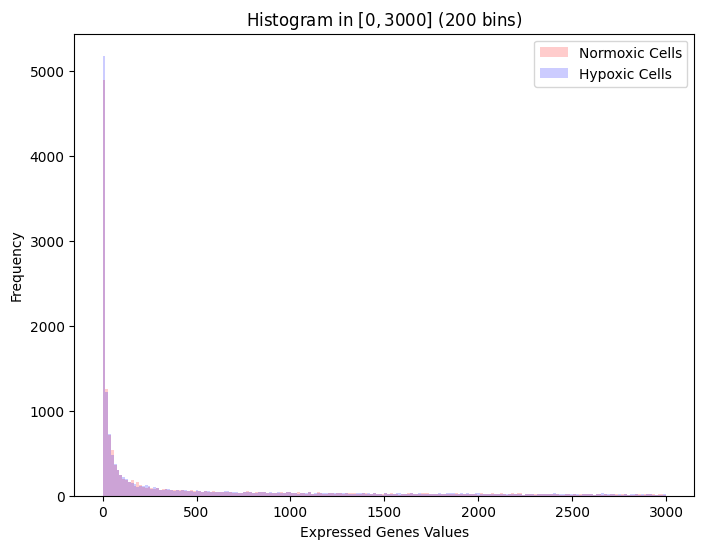

In [35]:
#check for the distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6)) 
ax.hist(m_unfiltered.loc[:, normoxic_cells].sum(axis = 1), range = [0, 3000], bins = 200, alpha = 0.2, color = "red", label = "Normoxic Cells")
ax.hist(m_unfiltered.loc[:, hypoxic_cells].sum(axis = 1), range = [0, 3000], bins = 200, alpha = 0.2, color = "blue", label = "Hypoxic Cells")
ax.set_xlabel("Expressed Genes Values")
ax.set_ylabel("Frequency")
ax.set_title("Histogram in $[0, 3000]$ (200 bins)")
ax.legend()
plt.show()

They follow a similar distribution pattern, with most gene expression values being 0, so the cells do not differ in the amount of genes they codify for.

Let's check the most expressed genes in each type.

In [36]:
#check for normoxic, hypoxic cells which are the top 10 expressed genes
print("Top 10 genes of normoxic cells:\n", m_unfiltered.loc[:, normoxic_cells].sum(axis = 1).nlargest(10))
print("Top 10 genes of hypoxic cells:\n", m_unfiltered.loc[:, hypoxic_cells].sum(axis = 1).nlargest(10))

Top 10 genes of normoxic cells:
 KRT8      5123523
KRT18     4334290
ACTB      2630013
KRT19     1756323
MT-CO1    1411951
GAPDH     1321369
ALDOA      845988
MT-CYB     812863
ACTG1      799736
MT-CO2     793004
dtype: int64
Top 10 genes of hypoxic cells:
 GAPDH     7426181
ACTB      4582142
ACTG1     4469395
ALDOA     4311890
KRT8      3705685
KRT19     3411113
KRT18     3016849
ENO1      1887918
CYP1B1    1881331
FTH1      1604435
dtype: int64


### Outliers

Let's study the outliers, using visual tools and the IQR technique.

First of all, let's visualise the violin plot and the box plot of a single column of our dataframe.

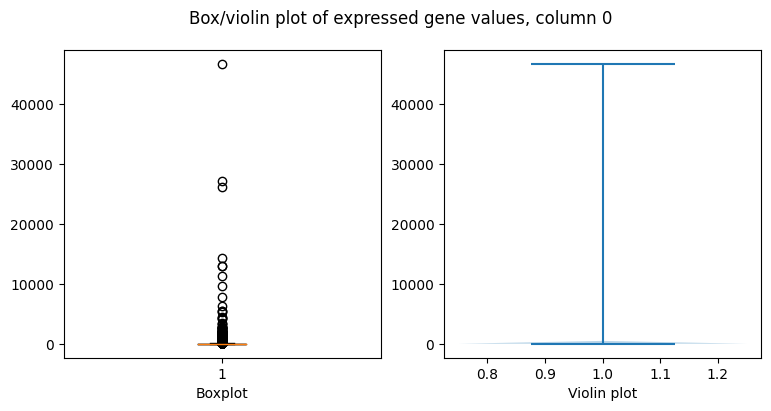

In [37]:
#boxplot and violin plot of a single column
col = m_unfiltered.iloc[:, 0]
fig, ax= plt.subplots(1,2, figsize=(9, 4))
plt.suptitle("Box/violin plot of expressed gene values, column 0")
ax[0].boxplot(col)
ax[1].violinplot(col)
ax[0].set_xlabel("Boxplot")
ax[1].set_xlabel("Violin plot")
plt.show()

Notice that, especially through the violin plot, most of the density of the distribution is around 0.

We've inspected a single cell. Now (and also a bit in subsequent sections) we'll be using a version of the original dataset which includes only 50 random columns, since generating the plots for all the 243 cells would take too much time in our setup.

In [38]:
#create smaller dataframe
random_columns = list(range(0, m_unfiltered.shape[1])) # list of integers from 1 to 243
random.shuffle(random_columns)
random_columns = random_columns[:50] 
m_unfiltered_small = m_unfiltered.iloc[:, random_columns]

First of all, let's look at the boxplot and the violin plots of the data.

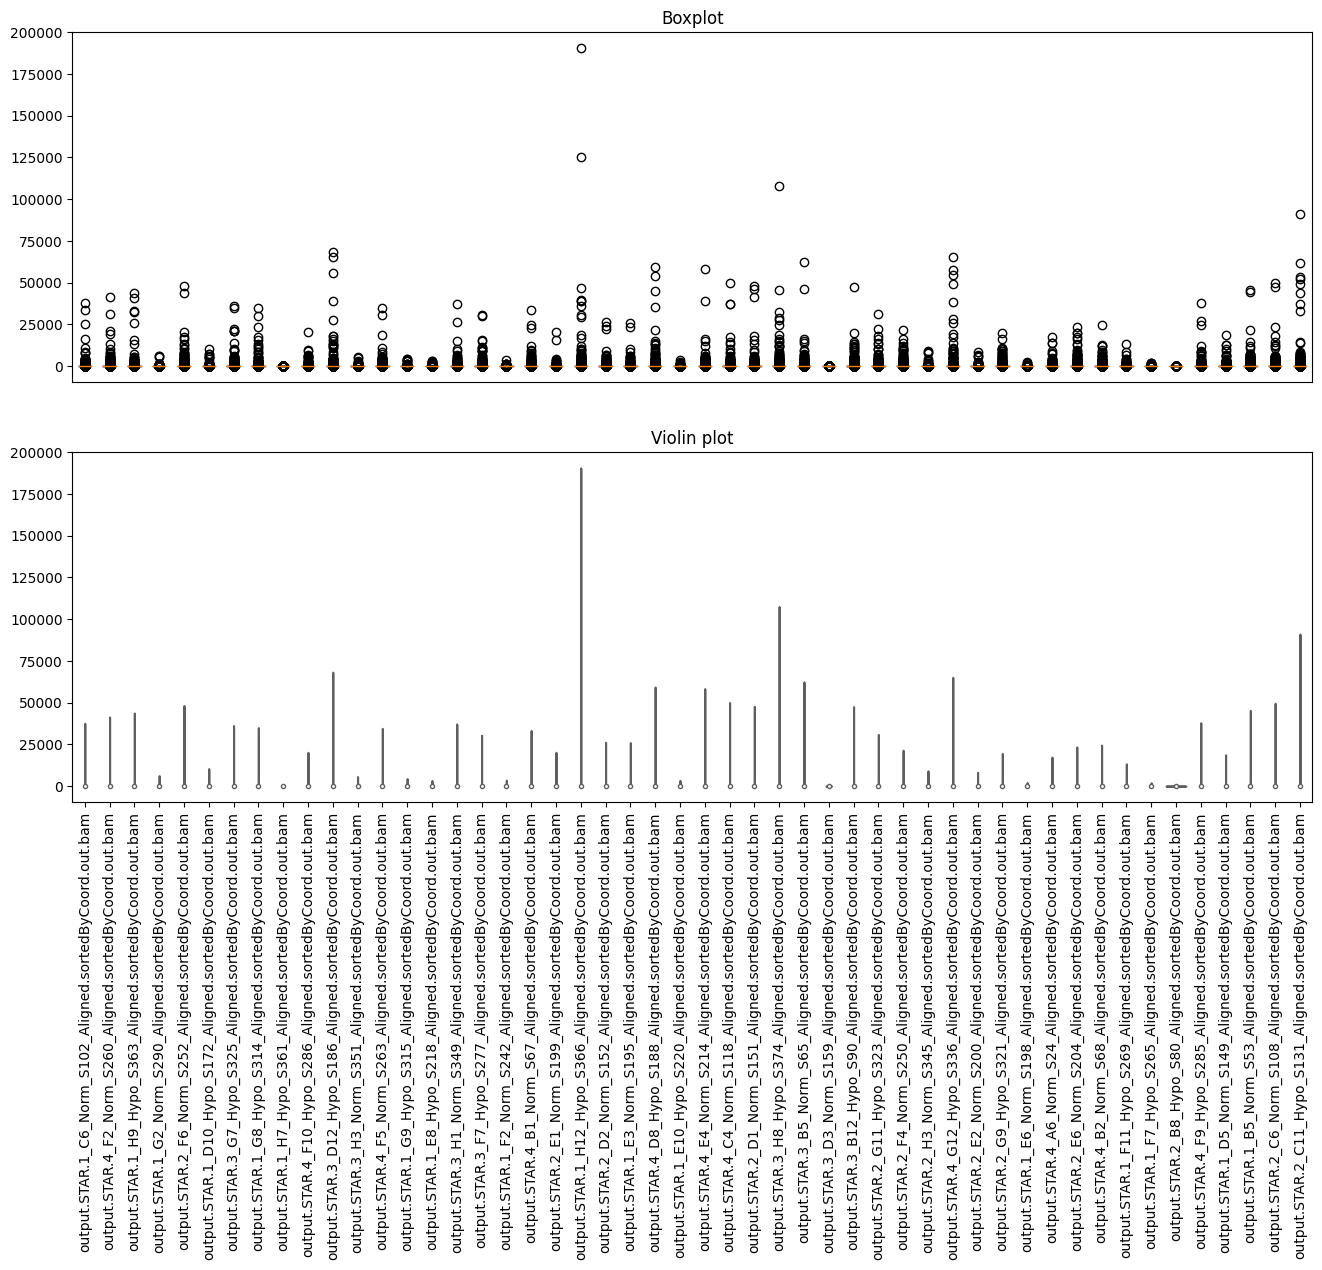

In [39]:
#boxplot and violinplot of smaller dataframe
fig, axs = plt.subplots(2, figsize=(16,10))
axs[0].boxplot(m_unfiltered_small)
axs[0].set_title("Boxplot")
axs[0].get_xaxis().set_visible(False)

violionplot_unfiltered=sns.violinplot(data=m_unfiltered_small,palette="Set3",cut=0, ax = axs[1])
plt.setp(violionplot_unfiltered.get_xticklabels(), rotation=90);
axs[1].set_title("Violin plot")

plt.show()

The outliers play an important role once again. Let's use the IQR rule.

In [40]:
column_outliers = {} # key:value is column:number of outliers
column_outliers_genes = {} # key:value is column: list of rows that are outliers

for col in m_unfiltered.columns:
    s = m_unfiltered[col]
    lower_quantile = s.quantile(0.25)
    upper_quantile = s.quantile(0.75)
    IQR = upper_quantile - lower_quantile
    boolean_out = (s < s.quantile(0.25) - 1.5 * IQR) | (s > s.quantile(0.75) + 1.5 * IQR)
    column_outliers[col] = boolean_out.value_counts().loc[True]

In [41]:
column_outliers

{'output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam': 3751,
 'output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam': 188,
 'output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam': 5329,
 'output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam': 4739,
 'output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam': 3511,
 'output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam': 3645,
 'output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam': 3457,
 'output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam': 3421,
 'output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam': 3344,
 'output.STAR.1_A7_Hypo_S25_Aligned.sortedByCoord.out.bam': 3548,
 'output.STAR.1_A8_Hypo_S26_Aligned.sortedByCoord.out.bam': 4594,
 'output.STAR.1_A9_Hypo_S27_Aligned.sortedByCoord.out.bam': 3722,
 'output.STAR.1_B10_Hypo_S76_Aligned.sortedByCoord.out.bam': 3673,
 'output.STAR.1_B11_Hypo_S77_Aligned.sortedByCoord.out.bam': 3369,
 'output.STAR.1_B12_Hypo_S78_Aligned.sortedByCoord.out.bam': 3160,
 'output.ST

In [42]:
print("Total number of outliers in the sample cells: ", sum(list(column_outliers.values())))
print("Proportion of outliers in the sample cells: ", round(sum(list(column_outliers.values())) / m_unfiltered.size, 5))

Total number of outliers in the sample cells:  1268914
Proportion of outliers in the sample cells:  0.14446


14% of the data is an outlier, just like in the HCC1806 cell line.

To avoid repeating the procedure, we skip the steps in which we try to remove the outliers to show that they're important. So we ask the reader to trust us that they're indeed important and carry a lot of information.

### Distributions

First of all, let's visualise the histogram of a single column of our dataframe.


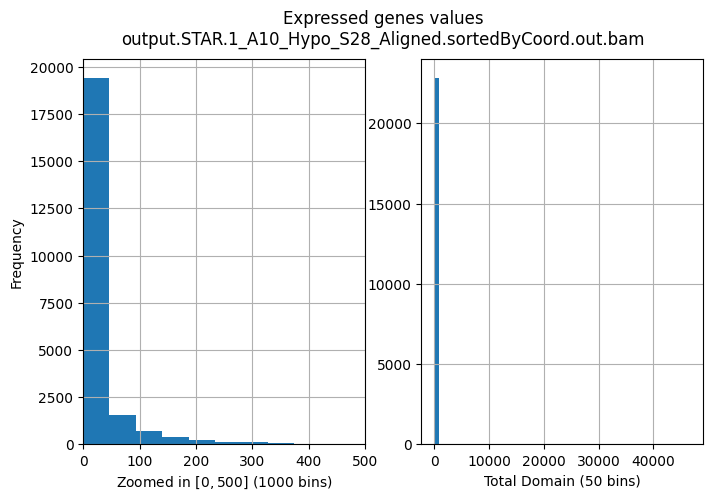

In [43]:
#histogram of a single column
col = m_unfiltered.iloc[:, 0]
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
col.hist(ax=axs[0], bins=1000)
col.hist(ax=axs[1], bins=50)
plt.suptitle(f"Expressed genes values\n{col.name}")
axs[0].set_xlim(0, 500)
axs[0].set_xlabel("Zoomed in $[0, 500]$ (1000 bins)")
axs[0].set_ylabel("Frequency")
axs[1].set_xlabel("Total Domain (50 bins)")
plt.show()

We see the same features, namely:
- few counts associated with a large proportion of genes
- a long right tail
- large dynamic range

Let's now study whether a Poisson distribution might be a good fit for the data, by analyzing the relation between the mean and the variance of our data.

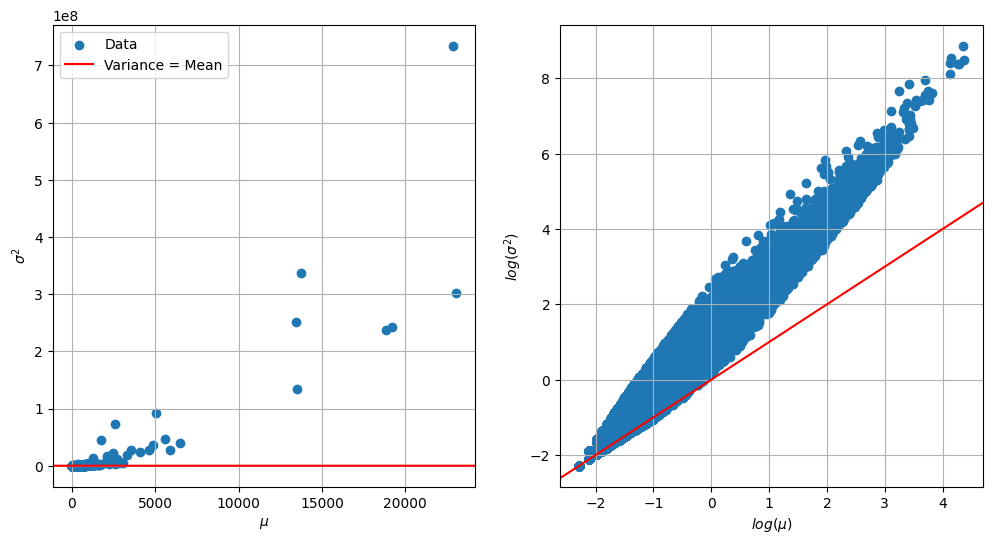

In [44]:
m_unfiltered_var = m_unfiltered.var(axis = 1)
m_unfiltered_mean = m_unfiltered.mean(axis = 1)

fig, ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(m_unfiltered_mean, m_unfiltered_var, label = "Data")
ax[0].set_xlabel("$\mu$")
ax[0].set_ylabel("$\sigma^2$")
ax[0].grid(True)
ax[0].axline((0,0), slope=1, color = 'r', label = "Variance = Mean")
ax[0].legend()

ax[1].scatter(m_unfiltered_mean.apply(np.log10), m_unfiltered_var.apply(np.log10), label = "Data")
ax[1].set_xlabel("$log(\mu)$")
ax[1].set_ylabel("$log(\sigma^2)$")
ax[1].grid(True)
ax[1] = plt.gca() 
ax[1].axline((0,0), slope=1, color = 'r', label = "Variance = Mean")

plt.show()

For already explained reasons, the Poisson is not a good fit. So heuristically, the Negative Binomial is the best distribution for our data.

Let's inspect the skewness and kurtosis for all cells in our sample.

In [45]:
skewness_list = []
kurtosis_list = []

for col in m_unfiltered.columns:
  skewness_list.append(skew(m_unfiltered[col]))
  kurtosis_list.append(kurtosis(m_unfiltered[col]))

skewness_series = pd.Series(skewness_list)
kurtosis_series = pd.Series(kurtosis_list)

In [46]:
print("Skewness\n", skewness_series.describe())
print("\nKurtosis\n", kurtosis_series.describe())

Skewness
 count    383.000000
mean      55.599580
std       15.259392
min        9.836728
25%       46.652455
50%       53.756294
75%       63.825136
max      151.429852
dtype: float64

Kurtosis
 count      383.000000
mean      4164.854641
std       2283.291287
min        282.371524
25%       2777.121626
50%       3691.001627
75%       5187.631119
max      22929.000044
dtype: float64


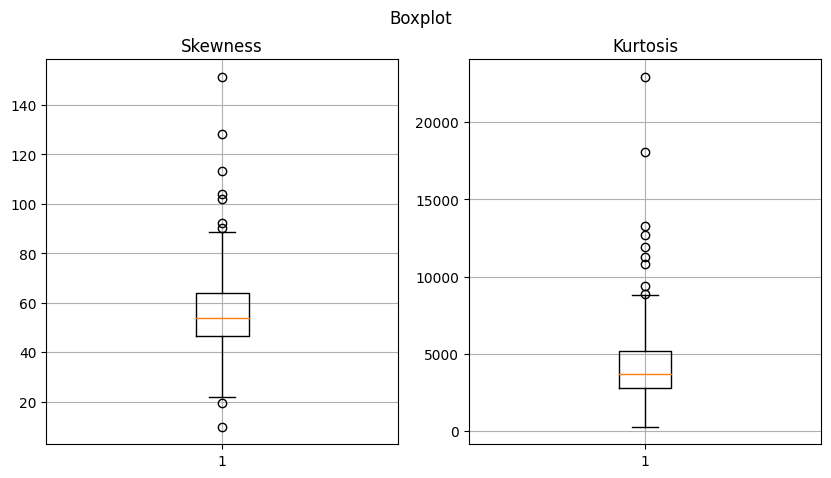

In [47]:
# boxplot of skewness
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle("Boxplot")
ax[0].boxplot(skewness_series)
ax[0].grid(True)
ax[0].set_title("Skewness")
ax[1].boxplot(kurtosis_series)
ax[1].grid(True)
ax[1].set_title("Kurtosis")
plt.show()

As imaginable, we see high values of skewness and kurtosis, which we'll address in the Data Preprocessing part.

### Correlation

We now want to check the correlation between samples and features. First, we proceed at looking the correlation between samples. Let's use both the Pearson correlation coefficient and Spearman's rank correlation

Number of cells included:  (383, 383)
Average between minimum and maximum correlation:  0.4989810753533692
Average correlation of expression profiles between genes:  0.672893145115795


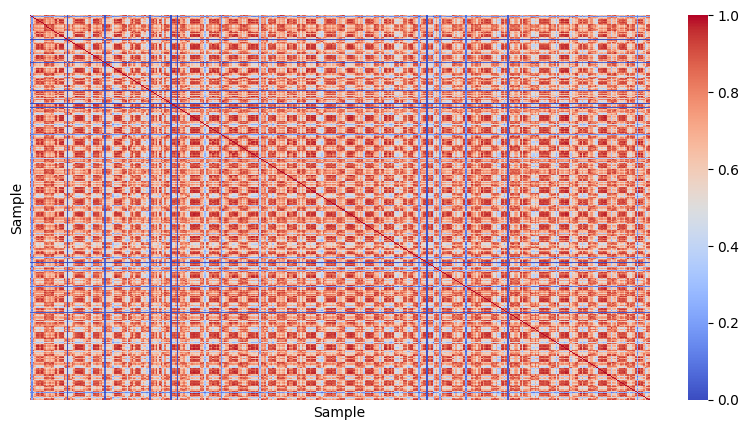

In [48]:
#pearson correlation coefficient
corr_matrix_p = m_unfiltered.corr(method = 'pearson')

average = (corr_matrix_p.values.max() - corr_matrix_p.values.min()) /2 + corr_matrix_p.values.min()
print("Number of cells included: ", np.shape(corr_matrix_p))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_p.mean().mean())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_p, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Number of cells included:  (383, 383)
Average between minimum and maximum correlation:  0.4958665547892621
Average correlation of expression profiles between genes:  0.6294472876076588


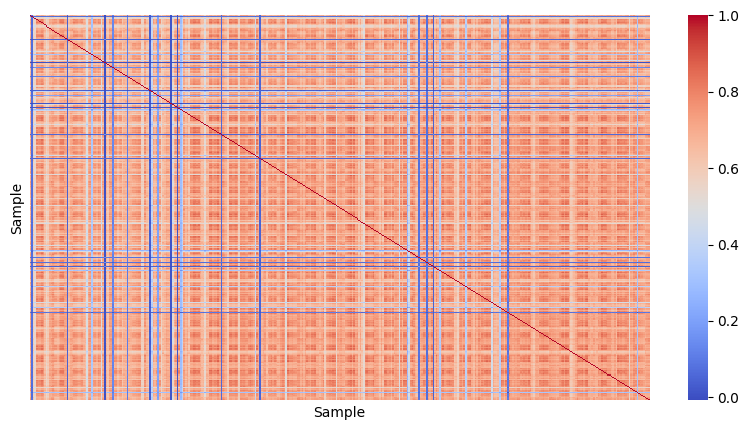

In [49]:
#spearman correlation coefficient
corr_matrix_s = m_unfiltered.corr(method = 'spearman')

average = (corr_matrix_s.values.max() - corr_matrix_s.values.min()) /2 + corr_matrix_s.values.min()
print("Number of cells included: ", np.shape(corr_matrix_s))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_s.mean().mean())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_s, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Immediately we see that most cells are positively correlated between them. However, notice that there seems to be no correlation between some samples. To check this, we can compute the minimum correlation. From now on, we are going to analyse the correlation using the Pearson correlation coefficient. 


In [50]:
print("Min. correlation of expression profiles between cells: ", corr_matrix_p.values.min())

Min. correlation of expression profiles between cells:  -0.0020378492932616927


This confirms that the correlation is mainly positive. By looking at the graph, moreover, we see some blue lines corresponding to some cells: these are the cells that have a low correlation with all other cells.

We now can plot the distribution of the correlation between gene expression profiles using a histogram (we do it on the first five variables in order not to lose too much time). 

[]

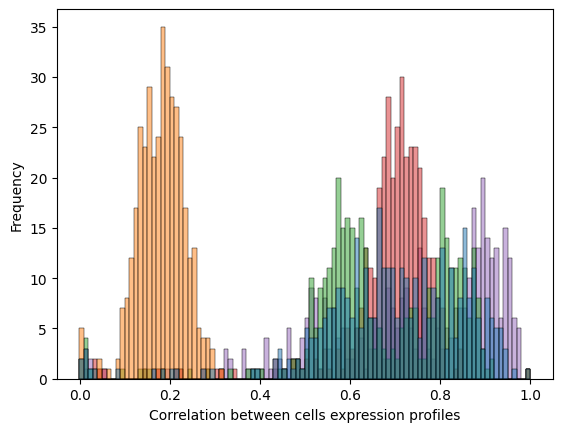

In [51]:
c = corr_matrix_p

c_small=corr_matrix_p.iloc[:,:5]
sns.histplot(c_small,bins=100)
plt.legend().set_visible(False);
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')
plt.plot()

The correlation is fairly high, apart from one, which seems pretty low.

Let's now focus on lowly and highly correlated cells, based on a correlation threshold.

In [52]:
#find low and high correlated cells
correlation_threshold = 0.5

low_corr_cells = (corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) <= correlation_threshold
high_corr_cells = ((corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) > correlation_threshold) & ((corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) <= 0.77)
very_high_corr_cells = (corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) > 0.77
# very_high_corr_cells.sum()

Now, let's analyse the distribution of the low correlated cells.

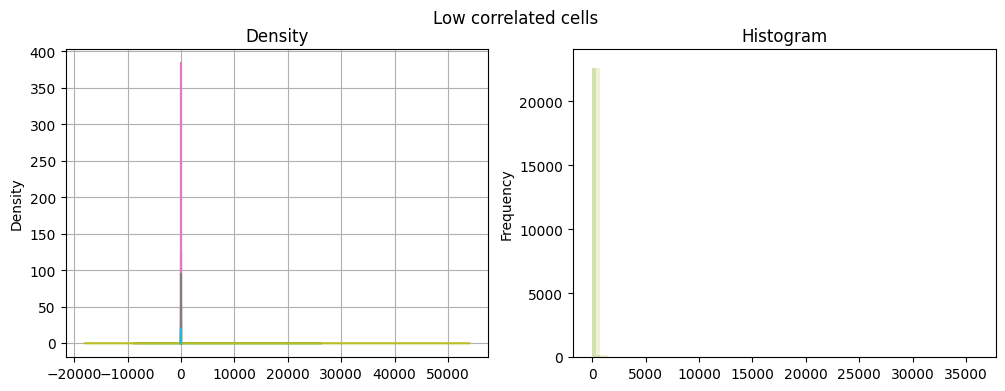

In [53]:
low_corr = m_unfiltered.loc[:, low_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("Low correlated cells")
for s in low_corr.columns[:10]:
    low_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[0].set_title("Density")
 
for s in low_corr.columns[:10]:
    ax[1].hist(low_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
ax[1].set_title("Histogram")
plt.show()

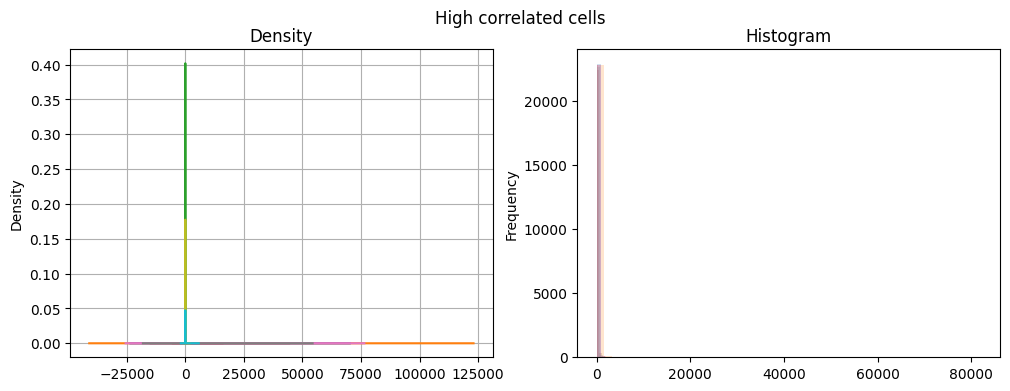

In [54]:
high_corr = m_unfiltered.loc[:, high_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("High correlated cells")
for s in high_corr.columns[:10]:
    high_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[0].set_title("Density")
 
for s in high_corr.columns[:10]:
    ax[1].hist(high_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
ax[1].set_title("Histogram")
plt.show()

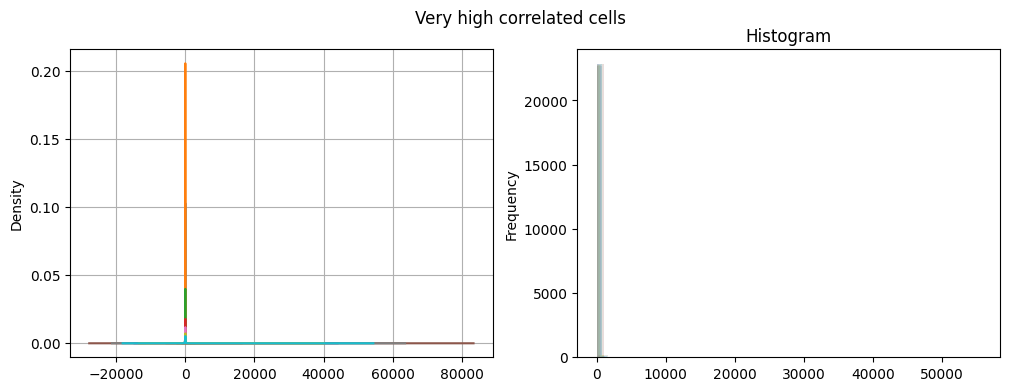

In [55]:
very_high_corr = m_unfiltered.loc[:, very_high_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("Very high correlated cells")
for s in very_high_corr.columns[:10]:
    very_high_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[1].set_title("Density")
 
for s in very_high_corr.columns[:10]:
    ax[1].hist(very_high_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
ax[1].set_title("Histogram")
plt.show()

Notice that the distributions seems to be rather similar. We are going to analyse why cells may have low correlation in the QC of cells.
Let's check other useful statistics: 

In [56]:
#average
print("Average expression low correlation: ", low_corr.mean().mean())
print("Average expression high correlation: ", high_corr.mean().mean())
print("Average expression very high correlation: ", very_high_corr.mean().mean())

Average expression low correlation:  13.005350758075972
Average expression high correlation:  45.43627403289963
Average expression very high correlation:  38.5031884974274


In [57]:
#sparsity of low_corr, high_corr and very_high_corr
sparsity_index_low = 1 - (np.count_nonzero(low_corr.values) / low_corr.size)
sparsity_index_high = 1 - (np.count_nonzero(high_corr.values) / high_corr.size)
sparsity_index_very_high = 1 - (np.count_nonzero(very_high_corr.values) / very_high_corr.size)
print("Low correlation: ", sparsity_index_low)
print("High correlation: ", sparsity_index_high)
print("Very High correlation: ", sparsity_index_very_high)

Low correlation:  0.9050650520956617
High correlation:  0.5843037396580588
Very High correlation:  0.5905751286299816


Notice that low-correlated cells have a more sparse expression with respect to the other ones. So, in general, they are less expressed.

Now let's analyse, using the Pearson correlation coefficient, the correlation between hypoxic and normoxic cells between them.

Hypoxic:
Number of cells included:  (191, 191)
Average between minimum and maximum correlation:  0.4990430458754979
Average correlation of expression profiles between genes:  0.7378155147621902
Min. correlation of expression profiles between cells:  -0.0019139082490041265
Normoxic:
Number of cells included:  (192, 192)
Average between minimum and maximum correlation:  0.4989810753533692
Average correlation of expression profiles between genes:  0.8182512186125148
Min. correlation of expression profiles between cells:  -0.0020378492932616927
Mixed:
Number of cells included:  (192, 191)
Average between minimum and maximum correlation:  0.4764009622532193
Average correlation of expression profiles between genes:  0.5675414736981849
Min. correlation of expression profiles between cells:  -0.0011401228737012838


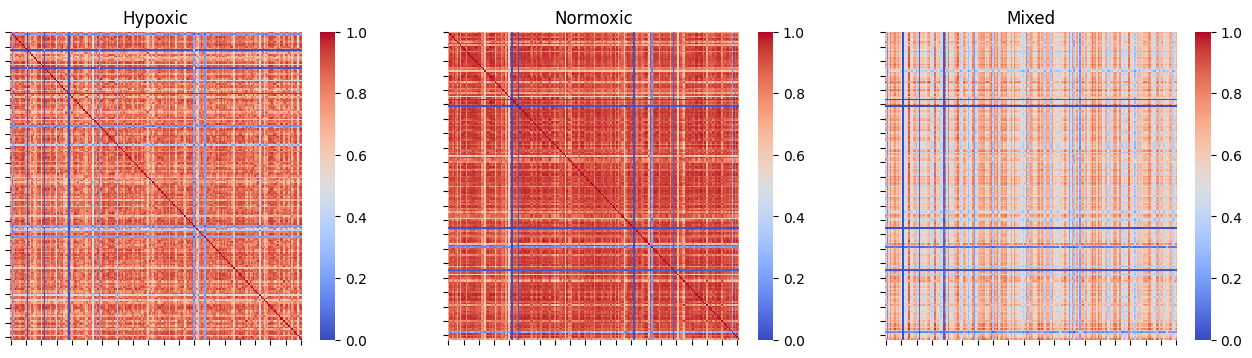

In [58]:
normoxic_cells = m_unfiltered.columns[m_unfiltered.columns.str.contains('Norm')].tolist()
hypoxic_cells = m_unfiltered.columns[m_unfiltered.columns.str.contains('Hypo')].tolist()

#correlation matrix between hypoxic cells
corr_matrix_hypoxic = corr_matrix_p.loc[hypoxic_cells, hypoxic_cells]
corr_matrix_hypoxic
print("Hypoxic:")
average = (corr_matrix_hypoxic.values.max() - corr_matrix_hypoxic.values.min()) /2 + corr_matrix_hypoxic.values.min()
print("Number of cells included: ", np.shape(corr_matrix_hypoxic))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_hypoxic.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_hypoxic.values.min())

#correlation matrix between normoxic cells
corr_matrix_normoxic = corr_matrix_p.loc[normoxic_cells, normoxic_cells]
corr_matrix_normoxic
print("Normoxic:")
average = (corr_matrix_normoxic.values.max() - corr_matrix_normoxic.values.min()) /2 + corr_matrix_normoxic.values.min()
print("Number of cells included: ", np.shape(corr_matrix_normoxic))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_normoxic.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_normoxic.values.min())

#correlation matrix between mixed cells
corr_matrix_mixed = corr_matrix_p.loc[normoxic_cells, hypoxic_cells]
corr_matrix_mixed
print("Mixed:")
average = (corr_matrix_mixed.values.max() - corr_matrix_mixed.values.min()) /2 + corr_matrix_mixed.values.min()
print("Number of cells included: ", np.shape(corr_matrix_mixed))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_mixed.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_mixed.values.min())

#Statistics:
fig, ax =plt.subplots(1,3, figsize = (16,4))

sns.heatmap(corr_matrix_hypoxic, cmap='coolwarm', ax=ax[0], vmin=0, vmax=1)
ax[0].set(title='Hypoxic', xticklabels=[], yticklabels=[])

sns.heatmap(corr_matrix_normoxic, cmap='coolwarm', ax=ax[1], vmin=0, vmax=1)
ax[1].set(title='Normoxic', xticklabels=[], yticklabels=[])

sns.heatmap(corr_matrix_mixed, cmap='coolwarm', ax=ax[2], vmin=0, vmax=1)
ax[2].set(title='Mixed', xticklabels=[], yticklabels=[])

plt.show()


Here normoxic seems to be more correlated between them than with the other cells. 

Let's analyse the correlation of genes using Pearson and Spearman correlation coefficients.

In [59]:
#pearson correlation coefficient
corr_matrix_p = m_unfiltered[:3000].transpose().corr(method = 'pearson')

average = (corr_matrix_p.values.max() - corr_matrix_p.values.min()) /2 + corr_matrix_p.values.min()
print("Number of cells included: ", np.shape(corr_matrix_p))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_p.mean().mean())
print("Min. correlation of expression profiles between genes: ", corr_matrix_p.values.min())

plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix_p, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Number of cells included:  (3000, 3000)
Average between minimum and maximum correlation:  0.27283370471328794
Average correlation of expression profiles between genes:  0.11191069429265595
Min. correlation of expression profiles between genes:  -0.4543325905734241


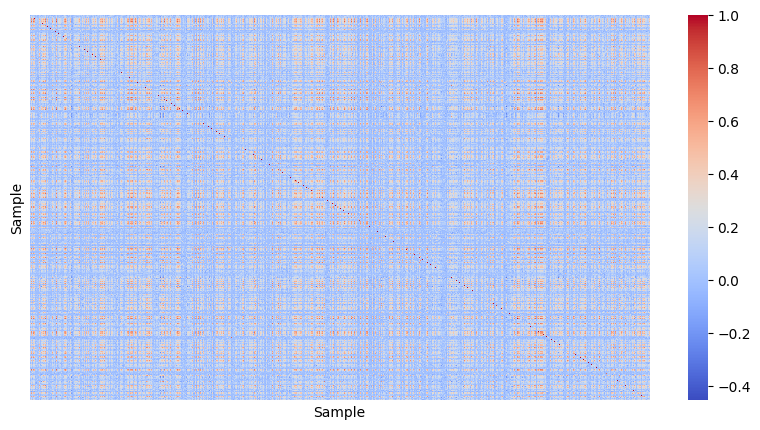

In [60]:
#spearman correlation coefficient
corr_matrix_s = m_unfiltered[:3000].transpose().corr(method = 'spearman')

average = (corr_matrix_s.values.max() - corr_matrix_s.values.min()) /2 + corr_matrix_s.values.min()
print("Number of cells included: ", np.shape(corr_matrix_s))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between genes: ", corr_matrix_s.mean().mean())
print("Min. correlation of expression profiles between genes: ", corr_matrix_s.values.min())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_s, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

For both correlation coefficients, most genes don't seem to be correlated, just like in the other cell line.

# **Data Preprocessing**

Let's now preprocess the data, to make it as good as possible.

In [61]:
# reupload the unfiltered file to avoid having conflicts with before
m_unfiltered = pd.read_csv(path_m_unfiltered, sep = " ")

We recall the steps:
- Quality Control (QC)
- Normalization and Scaling
- Feature Selection and Dimensionality Reduction

## Quality Control (QC)

### QC for Cells

We'll remove low-quality cells based on the following three covariates, considered jointly:
- Number of counts per cell (i.e. the count depth or library size)
- Number of detected genes per cell
- Fraction of mitochondrial genes count (denoted by MT) per cell

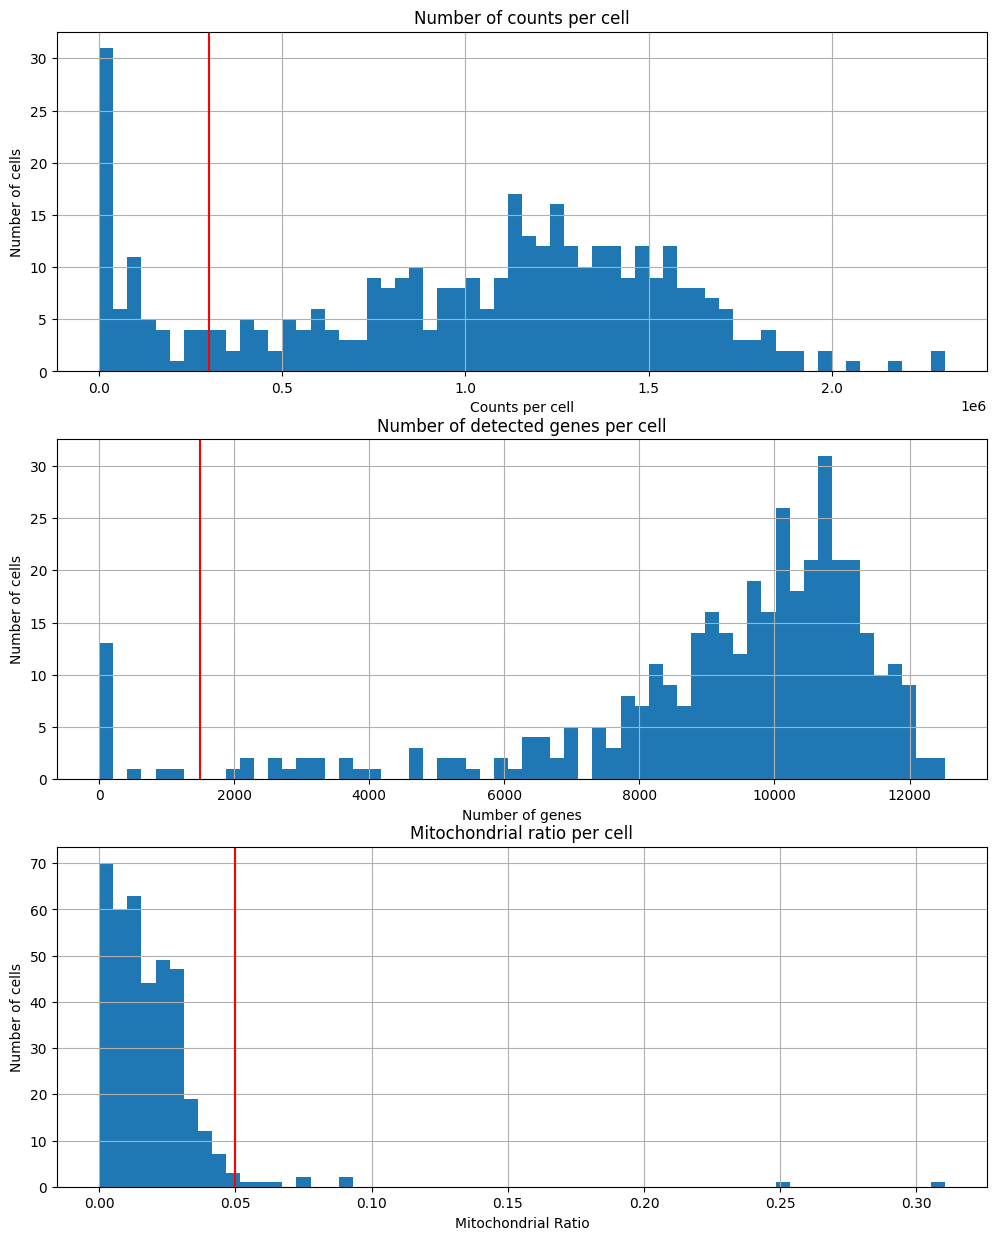

In [62]:
counts_per_cell = m_unfiltered.sum(axis = 0) # number of counts per cell
number_of_genes = np.count_nonzero(m_unfiltered, axis=0) #number of detected genes count
#mitochondrial count
mitochondrial_genes = m_unfiltered.index.str.startswith("MT-")
mitochondrial_threshold = 0.05
mitochondrial_ratio = m_unfiltered.loc[mitochondrial_genes, :].sum() / counts_per_cell

counts_per_cell_threshold = 300000
number_of_genes_threshold = 1500
mitochondrial_threshold = 0.05

#plotting
fig, ax = plt.subplots(3, 1, figsize = (12, 15))

ax[0].set_title("Number of counts per cell")
ax[0].hist(counts_per_cell, bins = 60)
ax[0].axvline(counts_per_cell_threshold, color = "r")
ax[0].set_xlabel("Counts per cell")
ax[0].set_ylabel("Number of cells")
ax[0].grid(True)
ax[1].set_title("Number of detected genes per cell")
ax[1].hist(number_of_genes, bins = 60)
ax[1].axvline(number_of_genes_threshold, color = "r")
ax[1].set_xlabel("Number of genes")
ax[1].set_ylabel("Number of cells")
ax[1].grid(True)
ax[2].set_title("Mitochondrial ratio per cell")
ax[2].hist(mitochondrial_ratio, bins = 60)
ax[2].axvline(mitochondrial_threshold, color = "r")
ax[2].set_xlabel("Mitochondrial Ratio")
ax[2].set_ylabel("Number of cells")
ax[2].grid(True)

plt.show()

For the thresholds we use 
- 300000 for the number of counts per cell
- 1500 for the number of detected genes per cell
- 5% for the mitochondrial ratio per cell

Let's filter.

In [63]:
#filtering wrt 3 metrics
m_unfiltered_filtered = m_unfiltered.loc[:, (mitochondrial_ratio < mitochondrial_threshold) & (number_of_genes > number_of_genes_threshold) & (counts_per_cell > counts_per_cell_threshold)]
m_unfiltered_filtered

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     1          
OR4F29                                                     0          
MTND1P23                                                   0          
...                                                      ...          
MT-TE                                                      4          
MT-CYB                                                   270          
MT-TT                                                      0          
MT-TP                                                      5          
MAFIP                                                      8          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          
...                                                      ...          
MT-TE                                                      0          
MT-CYB                                                    76          
MT-TT                                                      0          
MT-TP                                                      0          
MAFIP                                                      0          

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      3        
MT-CYB                                                   727        
MT-TT                                                      0        
MT-TP                                                      0        
MAFIP                                                      0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      3        
MT-CYB                                                  2717        
MT-TT                                                      1        
MT-TP                                                      1        
MAFIP                                                      0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                    10        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      0        
MT-CYB                                                  9326        
MT-TT                     

Hence, we have reduced to 309 cells.

In [64]:
m_unfiltered = m_unfiltered_filtered.copy()

### QC for Genes

Now we remove the duplicate rows.


In [65]:
#find duplicated rows
m_unfiltered_duplicate_rows = m_unfiltered[m_unfiltered.duplicated(keep=False)]
print("number of duplicate rows: ", m_unfiltered_duplicate_rows.shape[0])
print("duplicates: ")
m_unfiltered_duplicate_rows

number of duplicate rows:  189
duplicates: 


output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
GJA4                                                       0          
SHISAL2A                                                   0          
PCSK9                                                      0          
IL12RB2                                                    0          
MTND4P11                                                   0          
...                                                      ...          
SEZ6L                                                      0          
RPS3AP51                                                   0          
MIR3667HG                                                  0          
ADAMTS5                                                    0          
KRTAP10-6                                                  0          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
GJA4                                                       0          
SHISAL2A                                                   0          
PCSK9                                                      0          
IL12RB2                                                    0          
MTND4P11                                                   0          
...                                                      ...          
SEZ6L                                                      0          
RPS3AP51                                                   0          
MIR3667HG                                                  0          
ADAMTS5                                                    0          
KRTAP10-6                                                  0          

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
GJA4                                                       0        
SHISAL2A                                                   0        
PCSK9                                                      0        
IL12RB2                                                    0        
MTND4P11                                                   0        
...                                                      ...        
SEZ6L                                                      0        
RPS3AP51                                                   0        
MIR3667HG                                                  0        
ADAMTS5                                                    0        
KRTAP10-6                                                  0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
GJA4                                                       0        
SHISAL2A                                                   0        
PCSK9                                                      0        
IL12RB2                                                    0        
MTND4P11                                                   0        
...                                                      ...        
SEZ6L                                                      0        
RPS3AP51                                                   0        
MIR3667HG                                                  0        
ADAMTS5                                                    0        
KRTAP10-6                                                  0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
GJA4                                                       0        
SHISAL2A                                                   0        
PCSK9                                                      0        
IL12RB2                                                    0        
MTND4P11                                                   0        
...                                                      ...        
SEZ6L                                                      0        
RPS3AP51                                                   0        
MIR3667HG                 

189 rows are duplicates. Below we drop duplicates using pandas built-in method:

In [66]:
#create dataframe with no duplicates
m_unfiltered_noDup = m_unfiltered.drop_duplicates()
m_unfiltered_noDup

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     1          
OR4F29                                                     0          
MTND1P23                                                   0          
...                                                      ...          
MT-TE                                                      4          
MT-CYB                                                   270          
MT-TT                                                      0          
MT-TP                                                      5          
MAFIP                                                      8          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0          
MIR6859-1                                                  0          
WASH9P                                                     0          
OR4F29                                                     0          
MTND1P23                                                   0          
...                                                      ...          
MT-TE                                                      0          
MT-CYB                                                    76          
MT-TT                                                      0          
MT-TP                                                      0          
MAFIP                                                      0          

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     0        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      3        
MT-CYB                                                   727        
MT-TT                                                      0        
MT-TP                                                      0        
MAFIP                                                      0        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                     1        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      3        
MT-CYB                                                  2717        
MT-TT                                                      1        
MT-TP                                                      1        
MAFIP                                                      0        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                                     0        
MIR6859-1                                                  0        
WASH9P                                                    10        
OR4F29                                                     0        
MTND1P23                                                   0        
...                                                      ...        
MT-TE                                                      0        
MT-CYB                                                  9326        
MT-TT                     

Let's count the number of removed rows in non-duplicated dataframe, for safety.

In [67]:
m_unfiltered.shape[0] - m_unfiltered_noDup.shape[0]

135

In [68]:
removed_genes = list(set(m_unfiltered.index).difference(set(m_unfiltered_noDup.index)))
removed_genes

['FGD5P1',
 'NUTF2P3',
 'RPS3AP51',
 'EIF3KP3',
 'ART4',
 'CACYBPP1',
 'COP1P1',
 'OR2AT2P',
 'STRA6LP',
 'MIR19B1',
 'GABRR2',
 'CSMD1',
 'RBFOX1',
 'RNU6-181P',
 'OR2V2',
 'DPY19L4P2',
 'MTATP8P2',
 'PSG1',
 'RNU6-244P',
 'RPL12P50',
 'ITIH3',
 'CACNA1S',
 'LINC02381',
 'F13A1',
 'ALPK2',
 'CPA1',
 'CD84',
 'SOST',
 'MUCL3',
 'RGN',
 'RPL36AP39',
 'LINC01608',
 'PRKCB',
 'OTOP3',
 'MIR6832',
 'SLC2A9',
 'MFSD4BP1',
 'PON1',
 'KIF19',
 'DACT2',
 'ASGR1',
 'MILR1',
 'SNURF',
 'DBH',
 'TPH1',
 'TMEM95',
 'KNOP1P1',
 'LINC00842',
 'MYT1L',
 'LINC02385',
 'GRIN2B',
 'ZNF382',
 'CYP4F26P',
 'KRTAP5-5',
 'MSR1',
 'MIR664B',
 'CLEC18C',
 'LINC00595',
 'MUC6',
 'RPH3A',
 'LINC02742',
 'IGFL2',
 'RIMBP3B',
 'FAM107A',
 'SVOP',
 'S1PR1',
 'MT1M',
 'DOK5',
 'GALNT17',
 'LINC02280',
 'MIR3190',
 'MIR6883',
 'CD34',
 'BCAR4',
 'ADAMTS5',
 'CCDC194',
 'OR7E97P',
 'GAPDHP66',
 'LAP3P2',
 'BCL6B',
 'PABPC1P2',
 'ROS1',
 'DRD2',
 'PLD5',
 'CRP',
 'RHOT1P1',
 'MTRNR2L11',
 'ASPA',
 'CTSLP2',
 'TRAV32',

In [69]:
# updating the dataset
m_unfiltered = m_unfiltered_noDup.copy()

In [70]:
m_unfiltered.shape

(22799, 309)

## Normalization and Scaling

Let's normlize the data using the CPM technique, namely:

$$x_i = \frac{\text{read count of gene } X \text{ in cell } i}{\text{total counts of cell } i}\cdot 10^6$$

where $x_i$ is the gene expression of gene $X$ in cell $i$.

In [71]:
normalized_m_unfiltered = (m_unfiltered / m_unfiltered.sum(axis = 0)) * 10**6
normalized_m_unfiltered.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000          
mean                                           43.861573          
std                                           498.953275          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                            18.160220          
max                                         49934.195908          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000          
mean                                           43.861573          
std                                           524.419464          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             2.522179          
max                                         41387.440458          

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                           43.861573        
std                                           372.564142        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            21.004495        
max                                         31752.795098        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                           43.861573        
std                                           391.768989        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            17.840494        
max                                         36344.963784        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                           43.861573        
std                                           249.662101        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                            22.554343        
max                                         17079.999098        

       output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                           43.861573        
std                                           362.401861        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.694678        
75%                                            25.008423        
max                                         35409.148220        

       output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                           43.861573        
std                                           298.263290        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        


Again, let's see the behaviour on 50 random columns.

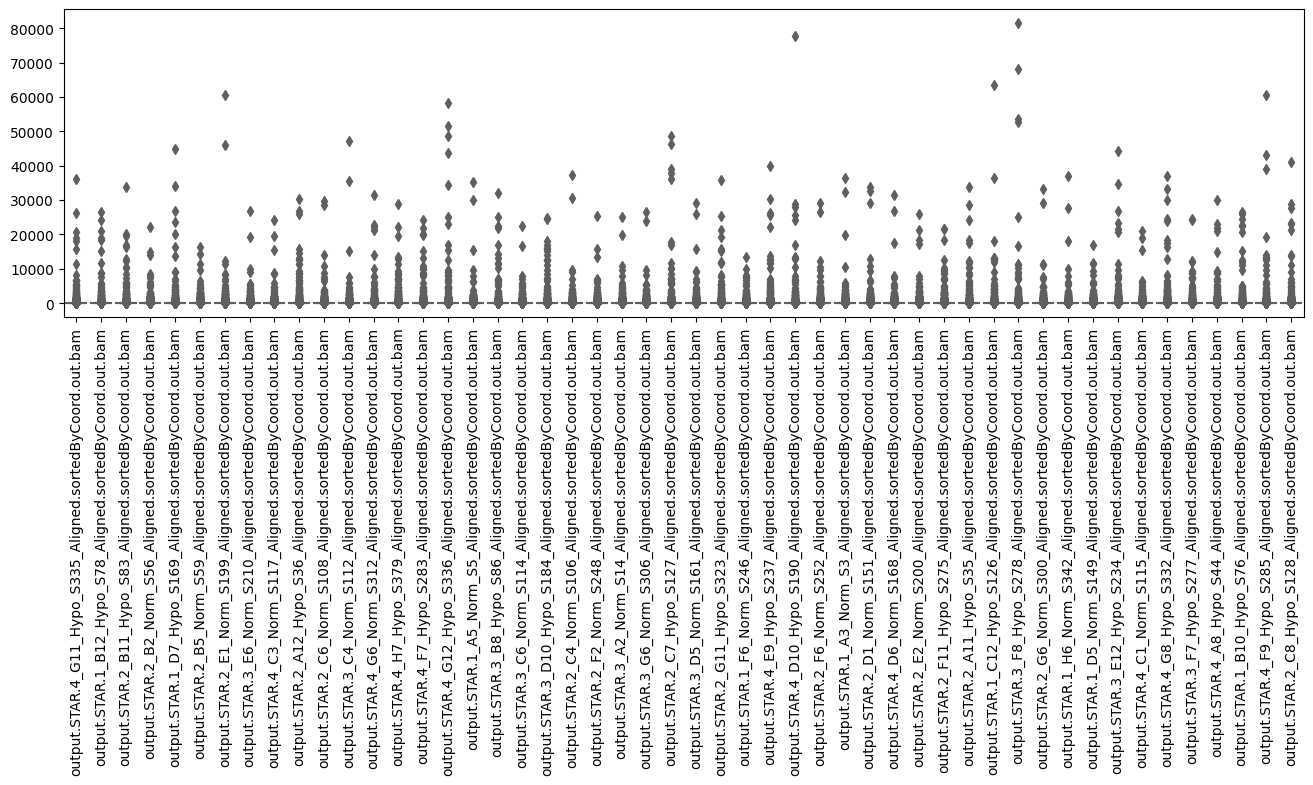

In [72]:
# box-plot of log-transformed 50 random columns of dataframe
random_columns = np.random.choice(normalized_m_unfiltered.columns, size=50, replace=False)
normalized_small = normalized_m_unfiltered.loc[:, random_columns]
plt.figure(figsize=(16,4))
plot = sns.boxplot(data=normalized_small, palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);

Surely the range has changed, and also the distribution of outliers, since they seem more compressed toward lower values, compared to before.
Let's see skewness and kurtosis.

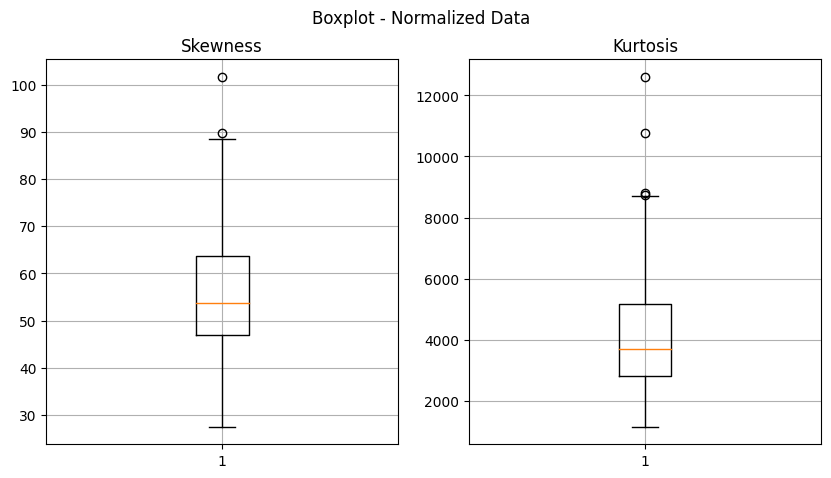

In [73]:
norm_skewness_list = []
norm_kurtosis_list = []

for col in normalized_m_unfiltered.columns:
  norm_skewness_list.append(skew(normalized_m_unfiltered[col]))
  norm_kurtosis_list.append(kurtosis(normalized_m_unfiltered[col]))

norm_skewness_series = pd.Series(norm_skewness_list)
norm_kurtosis_series = pd.Series(norm_kurtosis_list)

# boxplot of skewness
fig, ax = plt.subplots(1, 2, figsize=(10,5))
plt.suptitle("Boxplot - Normalized Data")
ax[0].boxplot(norm_skewness_series)
ax[0].grid(True)
ax[0].set_title("Skewness")
ax[1].boxplot(norm_kurtosis_series)
ax[1].grid(True)
ax[1].set_title("Kurtosis")
plt.show()


Again, skewness and kurtosis havent changed much, since we've just normalized the values.

In [74]:
# updating
m_unfiltered = normalized_m_unfiltered.copy()

Let's scale the values using the log transformation

In [75]:
log_m_unfiltered = np.log2(m_unfiltered + 1)
log_m_unfiltered.describe()

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000          
mean                                            1.934538          
std                                             2.788178          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             4.260042          
max                                            15.607769          

       output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000          
mean                                            1.484051          
std                                             2.672975          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             1.816468          
max                                            15.336940          

       output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                            2.194468        
std                                             2.814590        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             4.459726        
max                                            14.954641        

       output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                            2.045129        
std                                             2.786777        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             4.235765        
max                                            15.149508        

       output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                            2.218653        
std                                             2.833513        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        
75%                                             4.557921        
max                                            14.060105        

       output.STAR.1_A5_Norm_S5_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                            2.372727        
std                                             2.808138        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.761012        
75%                                             4.700907        
max                                            15.111875        

       output.STAR.1_A6_Norm_S6_Aligned.sortedByCoord.out.bam  \
count                                       22799.000000        
mean                                            2.249509        
std                                             2.841191        
min                                             0.000000        
25%                                             0.000000        
50%                                             0.000000        


Already at first glance, the range has dramatically decreased, as we saw previously by taking the $log$ just on the raw data.

Let's study the distributions of 50 random columns now.

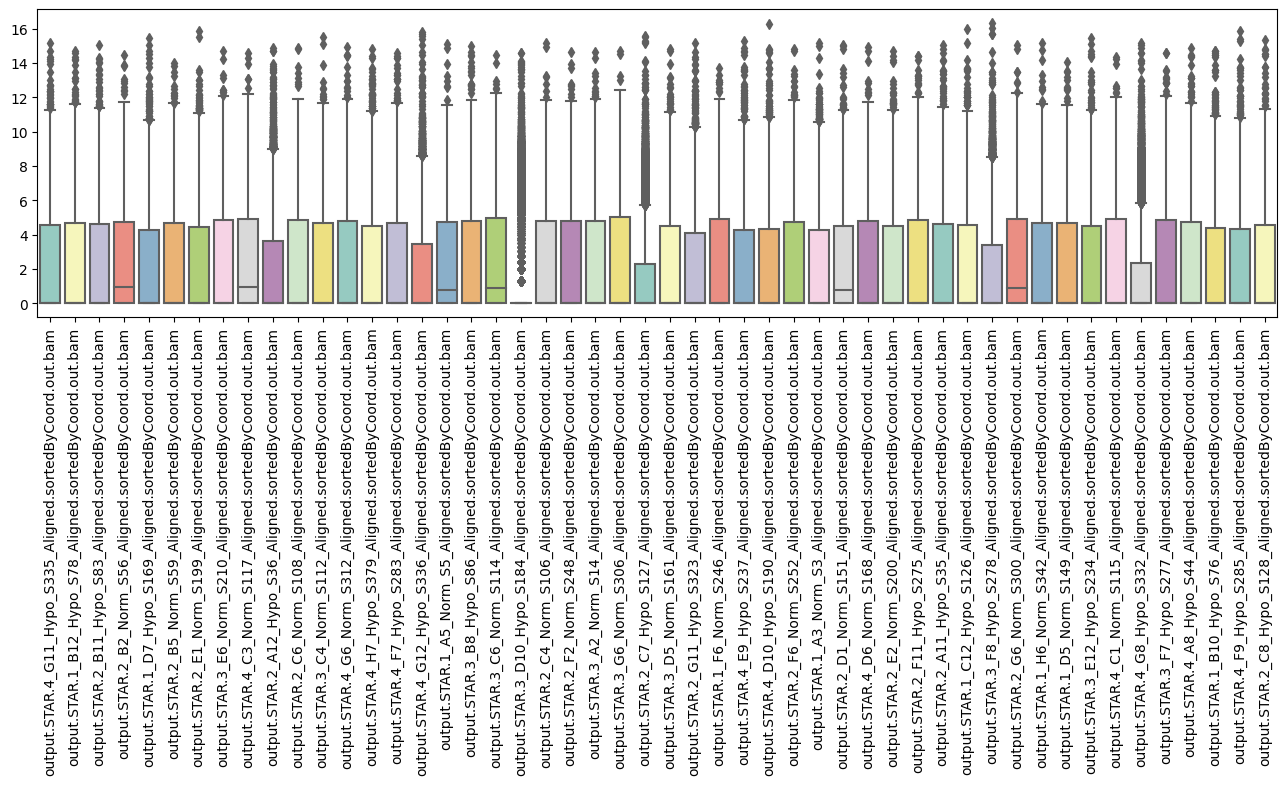

In [76]:
#box-plot of log-transformed 50 random columns of log-norm df
log_small = log_m_unfiltered.loc[:, random_columns]
plt.figure(figsize=(16,4))
plot=sns.boxplot(data=log_small,palette="Set3")
plt.setp(plot.get_xticklabels(), rotation=90);

Surely the range has decreased and the distribution is more symmetric. Moreover, we see that most values are within the quantiles and many outliers are far away. This might indicate, once again, the presence of a bimodal distribution. Let's verify it with 10 densities.

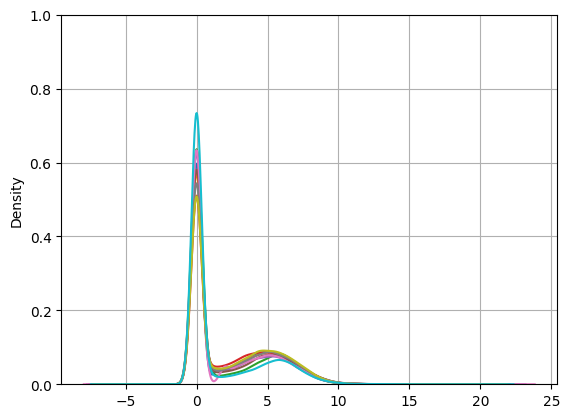

In [77]:
# 10 densities
fig, ax = plt.subplots(1,1)
for s in log_small.columns[:10]:
    log_small[s].plot.density(legend = False)
plt.ylim(0,1)
plt.grid(True)
plt.show()

Just like in the HCC1806 cell line, the data is bimodally distributed.

In [78]:
# updating
m_unfiltered = log_m_unfiltered.copy()

## A Note on Cell Cycles

Let's check if there any cell cycle.

In [79]:
h_cell_cycle = m_unfiltered.copy()

In [80]:
adata = sc.AnnData(h_cell_cycle).T
adata

AnnData object with n_obs × n_vars = 309 × 22799

In [81]:
# import cell cycle genes
cell_cycle_genes = [x.strip() for x in open('./regev_lab_cell_cycle_genes.txt')]
len(cell_cycle_genes) # 97

97

In [83]:
s_genes = cell_cycle_genes[:43] # S phase genes
g2m_genes = cell_cycle_genes[43:] #G2M phase genes
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names] # take only the ones in our dataset
len(cell_cycle_genes) # 94

94

Now we're ready to perform the cell-cycle scoring, on scaled data.

In [84]:
sc.pp.scale(adata) # scale data to unit variance and zero mean.
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

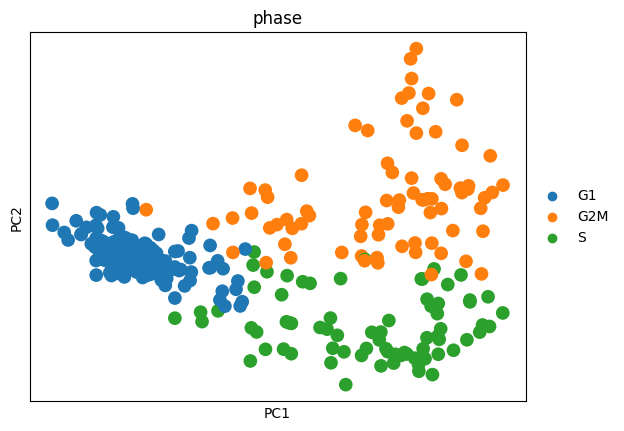

In [85]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

Cell cycle identified!
However, in this file we'll not regress it out, as we're not going to consider the data without it for reasons discussed in the HCC1806 cell line file.

## Feature selection

Now we filter out the dataframe as much as possible. First let's remove "undetectable" genes, with the CPM threshold set at 2.

In [86]:
mincpm_threshold = 0.5
mask_m_unfiltered = m_unfiltered > mincpm_threshold
mask_filtering = mask_m_unfiltered.sum(axis = 1) >= 2
m_unfiltered = m_unfiltered.loc[mask_filtering, :]
m_unfiltered

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000          
MIR6859-1                                           0.000000          
WASH9P                                              1.048409          
OR4F29                                              0.000000          
MTND1P23                                            0.000000          
...                                                      ...          
MT-TE                                               2.398622          
MT-CYB                                              8.177056          
MT-TT                                               0.000000          
MT-TP                                               2.664765          
MAFIP                                               3.254894          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000          
MIR6859-1                                           0.000000          
WASH9P                                              0.000000          
OR4F29                                              0.000000          
MTND1P23                                            0.000000          
...                                                      ...          
MT-TE                                               0.000000          
MT-CYB                                              5.297819          
MT-TT                                               0.000000          
MT-TP                                               0.000000          
MAFIP                                               0.000000          

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              0.000000        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        
...                                                      ...        
MT-TE                                               3.322206        
MT-CYB                                             11.091744        
MT-TT                                               0.000000        
MT-TP                                               0.000000        
MAFIP                                               0.000000        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              0.828366        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        
...                                                      ...        
MT-TE                                               1.734231        
MT-CYB                                             11.042005        
MT-TT                                               0.828366        
MT-TP                                               0.828366        
MAFIP                                               0.000000        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
WASH7P                                              0.000000        
MIR6859-1                                           0.000000        
WASH9P                                              2.761959        
OR4F29                                              0.000000        
MTND1P23                                            0.000000        
...                                                      ...        
MT-TE                                               0.000000        
MT-CYB                                             12.397241        
MT-TT                     

We could also additionally remove those such that they are not detected in at least $n$ cells. That is:

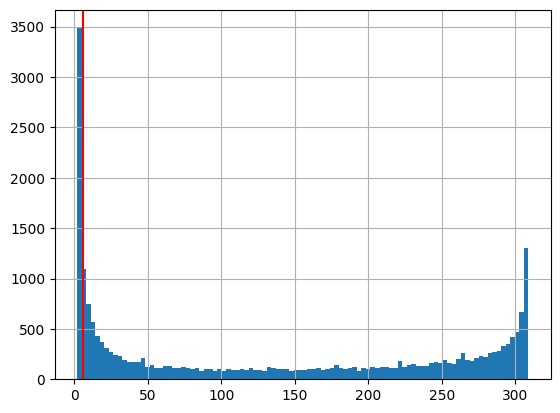

In [87]:
#number of cells expressing a gene
number_cell_per_gene = m_unfiltered.astype(bool).sum(axis = 1)
number_cell_per_gene_threshold = 6
plt.hist(number_cell_per_gene, bins = 100)
plt.axvline(x = number_cell_per_gene_threshold, color = 'r')
# plt.xlabel()
plt.grid(True)
plt.show()

In [88]:
#number of genes with less than threshold cell expressing them
number_cell_per_gene[number_cell_per_gene < number_cell_per_gene_threshold].size

3494

In [89]:
m_unfiltered = m_unfiltered.loc[number_cell_per_gene >= number_cell_per_gene_threshold, :]
m_unfiltered.shape

(18941, 309)

We have removed 3494 additional genes. Now let's keep only the highly variable genes.

In [90]:
#take dataset not transformed
m_unfiltered_HVG = pd.read_csv(path_m_unfiltered, sep = " ")
m_unfiltered_HVG = m_unfiltered_HVG.loc[m_unfiltered.index, m_unfiltered.columns]
adata = sc.AnnData(m_unfiltered_HVG.transpose().copy())

In [91]:
#compute highly variable genes
adata.raw=adata
result = sc.pp.highly_variable_genes(adata, n_top_genes = 3000, inplace = False, subset = False, flavor='seurat_v3')
sc.pp.highly_variable_genes(adata, n_top_genes = 3000,  flavor='seurat_v3')
adata

AnnData object with n_obs × n_vars = 309 × 18941
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

Now let's visualize which genes we have chosen:

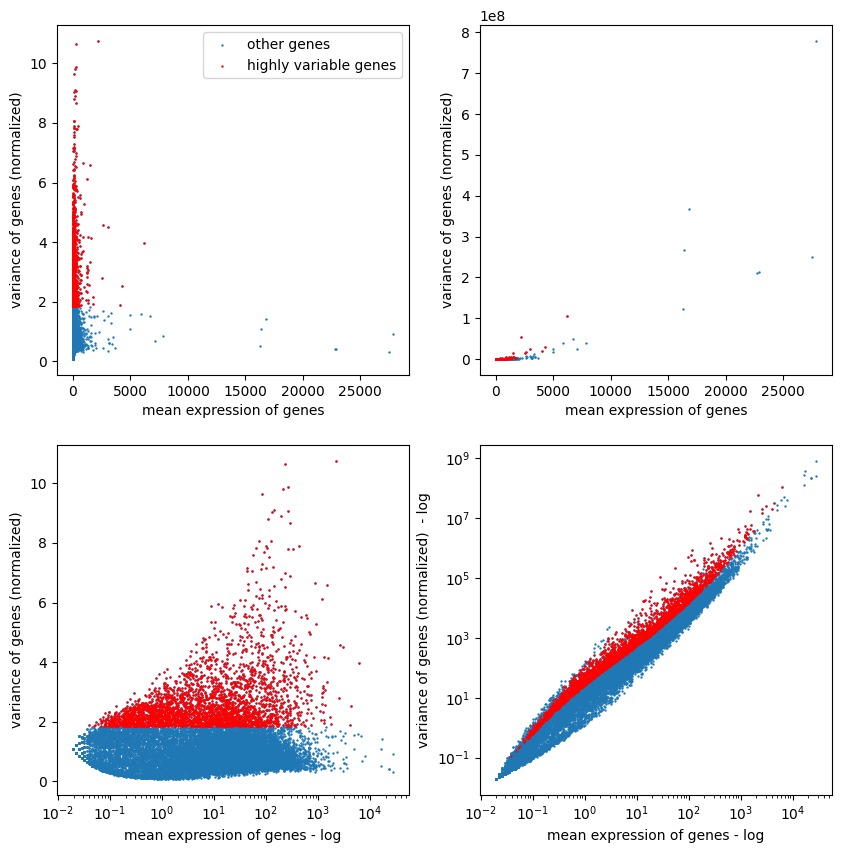

In [92]:
fig, ax = plt.subplots(2, 2, figsize = (10,10))

ax[0][0].scatter(adata.var['means'], adata.var['variances_norm'], s = 0.5)
ax[0][0].scatter(adata[:, adata.var['highly_variable']].var['means'], adata[:, adata.var['highly_variable']].var['variances_norm'], color = 'r', s = 0.5)
ax[0][0].set_xlabel('mean expression of genes')
ax[0][0].set_ylabel('variance of genes (normalized)')
legend_drawn_flag = True
ax[0][0].legend(["other genes", "highly variable genes"], loc=0, frameon=legend_drawn_flag)

ax[0][1].scatter(adata.var['means'], adata.var['variances'], s = 0.5)
ax[0][1].scatter(adata[:, adata.var['highly_variable']].var['means'], adata[:, adata.var['highly_variable']].var['variances'], color = 'r', s = 0.5)
ax[0][1].set_xlabel('mean expression of genes')
ax[0][1].set_ylabel('variance of genes (normalized)')

ax[1][0].scatter(adata.var['means'], adata.var['variances_norm'], s = 0.5)
ax[1][0].scatter(adata[:, adata.var['highly_variable']].var['means'], adata[:, adata.var['highly_variable']].var['variances_norm'], color = 'r', s = 0.5)
ax[1][0].set_xlabel('mean expression of genes - log')
ax[1][0].set_ylabel('variance of genes (normalized)')
ax[1][0].set_xscale('log')

ax[1][1].scatter(adata.var['means'], adata.var['variances'], s = 0.5)
ax[1][1].scatter(adata[:, adata.var['highly_variable']].var['means'], adata[:, adata.var['highly_variable']].var['variances'], color = 'r', s = 0.5)
ax[1][1].set_xlabel('mean expression of genes - log')
ax[1][1].set_ylabel('variance of genes (normalized)  - log')
ax[1][1].set_xscale('log')
ax[1][1].set_yscale('log')

Just to check, we can see the performance of our method with the given train dataframe:


In [93]:
#performance with given dataframe
adata = adata[:, adata.var['highly_variable']]
m_filtered_normalised = pd.read_csv(path_m_filtered_norm_train, sep = " ")

print("Total matching: ", adata.var['highly_variable'].index.isin(m_filtered_normalised.index).astype(bool).sum())
print("Percentage matching to the given training dataset: ", round(adata.var['highly_variable'].index.isin(m_filtered_normalised.index).astype(bool).sum()/3000*100, 2), "%")

Total matching:  2363
Percentage matching to the given training dataset:  78.77 %


In [94]:
# we're switching the naming from unfiltered to filtered
m_filtered_adata = adata.to_df().transpose()
m_filtered = m_unfiltered.loc[m_filtered_adata.index, :]
m_filtered

output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam  \
LINC02593                                           0.000000          
ISG15                                               7.213525          
C1QTNF12                                            0.000000          
SCNN1D                                              0.000000          
LINC01770                                           0.000000          
...                                                      ...          
COL18A1                                             0.000000          
PCBP3                                               3.546275          
COL6A1                                              0.000000          
FTCD                                                0.000000          
LSS                                                 0.000000          

           output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam  \
LINC02593                                            0.00000          
ISG15                                                0.00000          
C1QTNF12                                             0.00000          
SCNN1D                                               0.00000          
LINC01770                                            0.00000          
...                                                      ...          
COL18A1                                              6.43886          
PCBP3                                                0.00000          
COL6A1                                               0.00000          
FTCD                                                 0.00000          
LSS                                                  0.00000          

           output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam  \
LINC02593                                           0.000000        
ISG15                                               6.644162        
C1QTNF12                                            0.000000        
SCNN1D                                              0.000000        
LINC01770                                           0.000000        
...                                                      ...        
COL18A1                                             7.055589        
PCBP3                                               3.322206        
COL6A1                                              0.000000        
FTCD                                                0.000000        
LSS                                                 5.858284        

           output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord.out.bam  \
LINC02593                                           0.000000        
ISG15                                               8.289193        
C1QTNF12                                            0.000000        
SCNN1D                                              0.000000        
LINC01770                                           0.000000        
...                                                      ...        
COL18A1                                             8.529216        
PCBP3                                               0.000000        
COL6A1                                              0.000000        
FTCD                                                0.000000        
LSS                                                 7.322046        

           output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord.out.bam  \
LINC02593                                           0.000000        
ISG15                                               8.166247        
C1QTNF12                                            0.000000        
SCNN1D                                              0.000000        
LINC01770                                           0.000000        
...                                                      ...        
COL18A1                                             6.520354        
PCBP3                                               4.724974        
COL6A1                    

So this is our new filtered dataframe that we'll use from now use. As we can see it has 309 cells and 3000 genes.


## Dimensionality Reduction

Let's visualize our data in lower dimensional spaces to uncover some structure. Compared to before, we'll now try to be more extensive in the explanation, since the results will be unique to our data only.

In [95]:
# auxiliary variables and functions that we'll need
m_filtered = m_filtered.transpose() # columns are features (genes)

counts_per_cell = m_filtered.sum(axis = 1) # number of counts per cell
number_of_genes = np.count_nonzero(m_filtered, axis=1) #number of detected genes count
cell_types = pd.Series(index=m_filtered.index) # type of each cell
for i, col in enumerate(m_filtered.index):
    if "Norm" in m_filtered.index[i]:
        cell_types[col] = 'Normoxia'
    else:
        cell_types[col] = 'Hypoxia'

# type1
colors1 = counts_per_cell
# type2
cmap = {'Hypoxia': 'red', 'Normoxia': 'blue'}
colors2 = [cmap[cell_type] for cell_type in cell_types]

def plot_dim_red(dim_type, df, ax1, ax2, ax3):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(17.5, 11))

  plt.suptitle(f"{dim_type} Visualization")

  # counts per cell - 2D
  sctr2d = axs[0, 0].scatter(df[:, 0], df[:, 1], c=colors1)
  axs[0, 0].set_xlabel(ax1)
  axs[0, 0].set_ylabel(ax2)
  axs[0, 0].grid(True)
  if dim_type == "PCA":
    axs[0, 0].set_title(f"Explained Variance:{round(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1], 2)}")

  # counts per cell - 3D
  axs[0, 1].remove()
  axs[0, 1] = fig.add_subplot(222, projection='3d')
  sctr3d = axs[0, 1].scatter(df[:, 0], df[:, 1], df[:, 2], c=colors1)
  axs[0, 1].set_xlabel(ax1)
  axs[0, 1].set_ylabel(ax2)
  axs[0, 1].set_zlabel(ax3)
  if dim_type == "PCA":
    axs[0, 1].set_title(f"Explained Variance:{round(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2], 2)}")
  fig.colorbar(sctr3d, ax=axs[0, 1], label="Counts per cell")

  # hypoxia normoxia - 2D
  sctr2d = axs[1, 0].scatter(df[:, 0], df[:, 1], c=colors2)
  axs[1, 0].set_xlabel(ax1)
  axs[1, 0].set_ylabel(ax2)
  axs[1, 0].grid(True)
  handles = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=val, label=key)[0] for key, val in cmap.items()]
  axs[1, 0].legend(handles=handles, numpoints=1, loc='lower right')

  # hypoxia normoxia - 3D
  axs[1, 1].remove()
  axs[1, 1] = fig.add_subplot(224, projection='3d')
  sctr3d = axs[1, 1].scatter(df[:, 0], df[:, 1], df[:, 2], c=colors2)
  axs[1, 1].set_xlabel(ax1)
  axs[1, 1].set_ylabel(ax2)
  axs[1, 1].set_zlabel(ax3)

  plt.tight_layout()


<ipython-input-95-27abbe063973>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cell_types = pd.Series(index=m_filtered.index) # type of each cell


### PCA

In [96]:
m_filtered_scaled = StandardScaler().fit_transform(m_filtered) # unit variance, zero mean

pca = PCA()
m_filtered_pca = pca.fit_transform(m_filtered_scaled)

In [97]:
print(f"Explained Variance Ratio PC1: {round(pca.explained_variance_ratio_[0], 4)}\
      \nExplained Variane Ratio PC2: {round(pca.explained_variance_ratio_[1], 4)}\
      \nExplained Variance Ratio PC3: {round(pca.explained_variance_ratio_[2], 4)}")

Explained Variance Ratio PC1: 0.087      
Explained Variane Ratio PC2: 0.0357      
Explained Variance Ratio PC3: 0.0227


The first three principal components capture respectively 8%, 3.6%, 2.3% of the variance. Let's see at least a plot of how many dimensions would be needed to capture 95% of the variance.

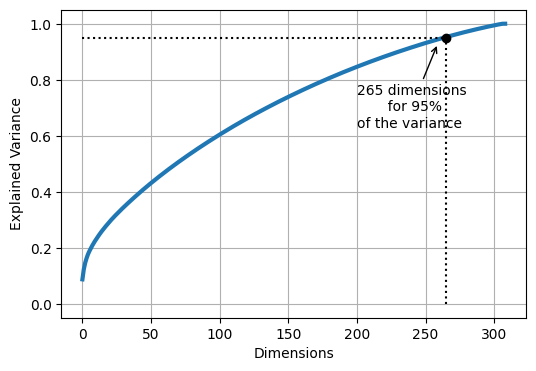

In [98]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate(f"{d} dimensions\n       for 95%\nof the variance", xy=(259, 0.93), xytext=(200, 0.63),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

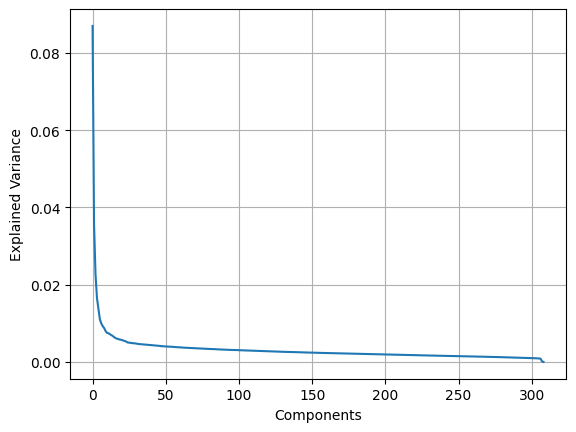

In [99]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.grid(True)
plt.show()

Now we need 265 dimensions to capture 95% of the variance. Moreover, we can see that at around 25 principal components most of the variance is captured, as the next components do not give more contribution. We could've adopted the Elbow method to select the optimal number of components, but we avoided using it as it would've been useless in our scenario. Let's now do the plots.

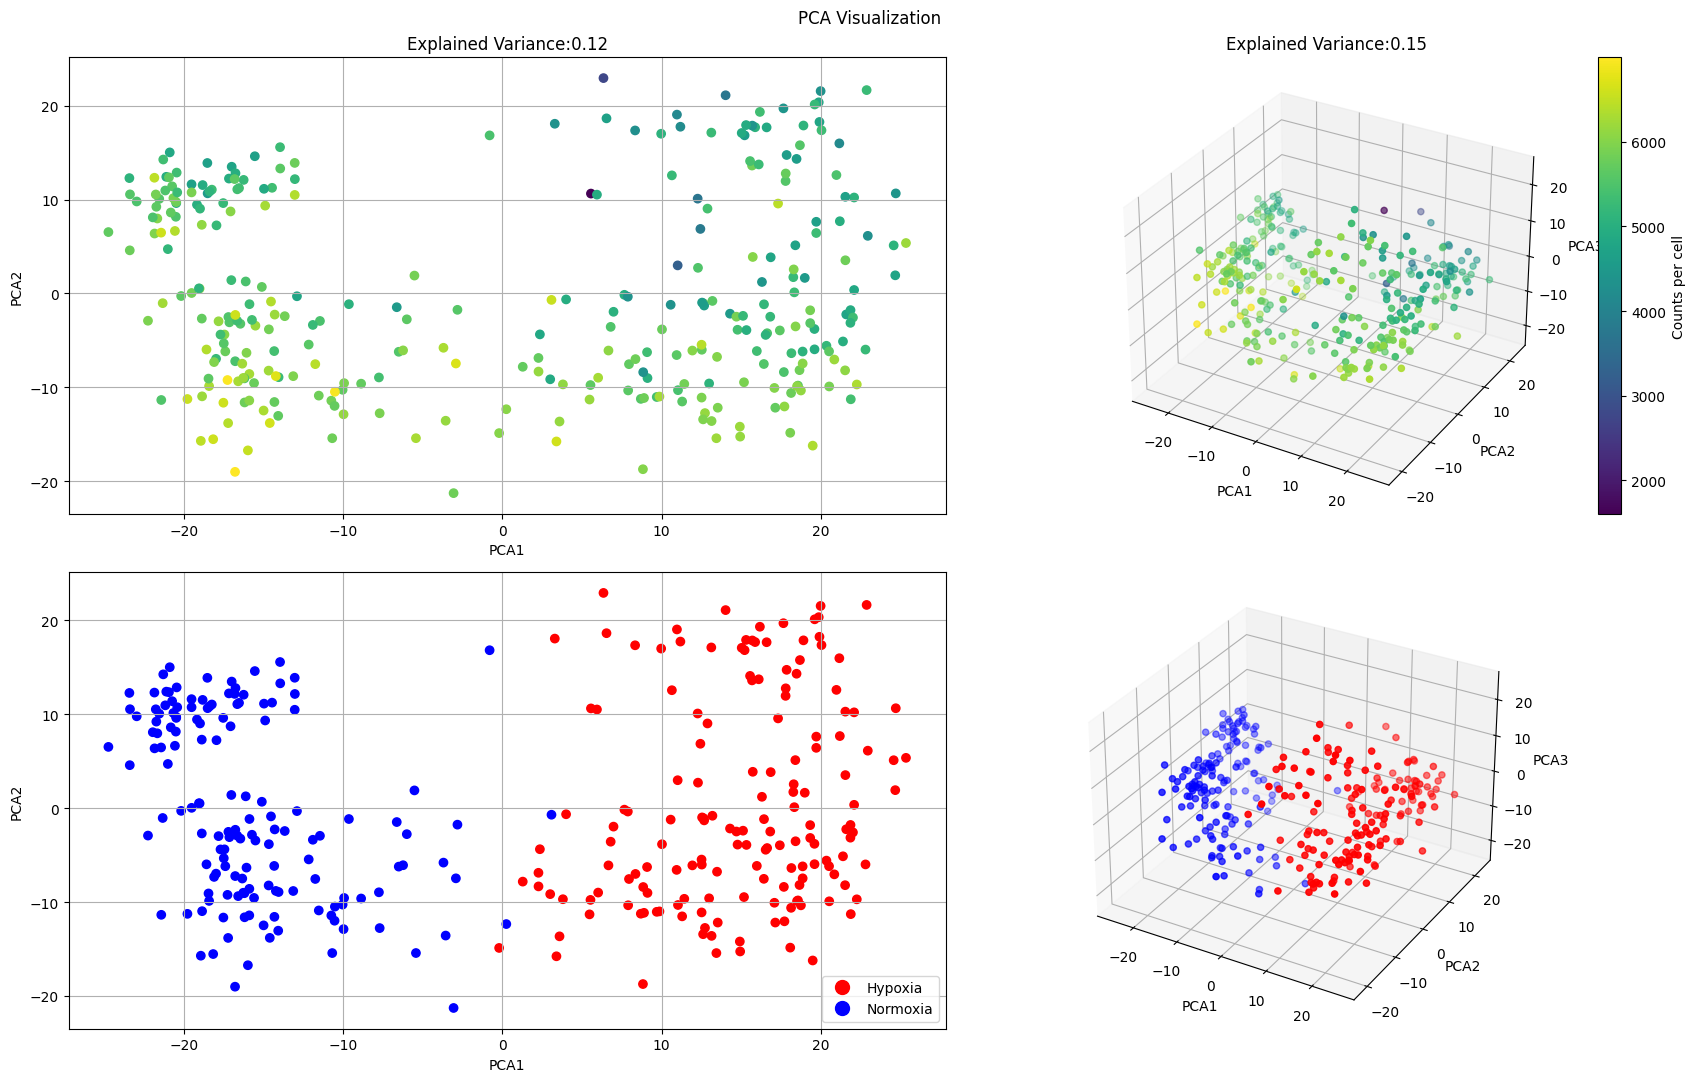

In [100]:
plot_dim_red("PCA", m_filtered_pca, "PCA1", "PCA2", "PCA3")
plt.show()

Not much seems to emerge from the number of counts, but there is a clear separation between hypoxic and normoxic cells. Moreover, we see that normoxic cells have 2 intra-clusters, indicating the presence of sub-defining genes.


### t-SNE

In [101]:
tsne = TSNE(n_components = 3, perplexity=60, random_state = 42)
m_filtered_tsne = tsne.fit_transform(m_filtered_scaled)

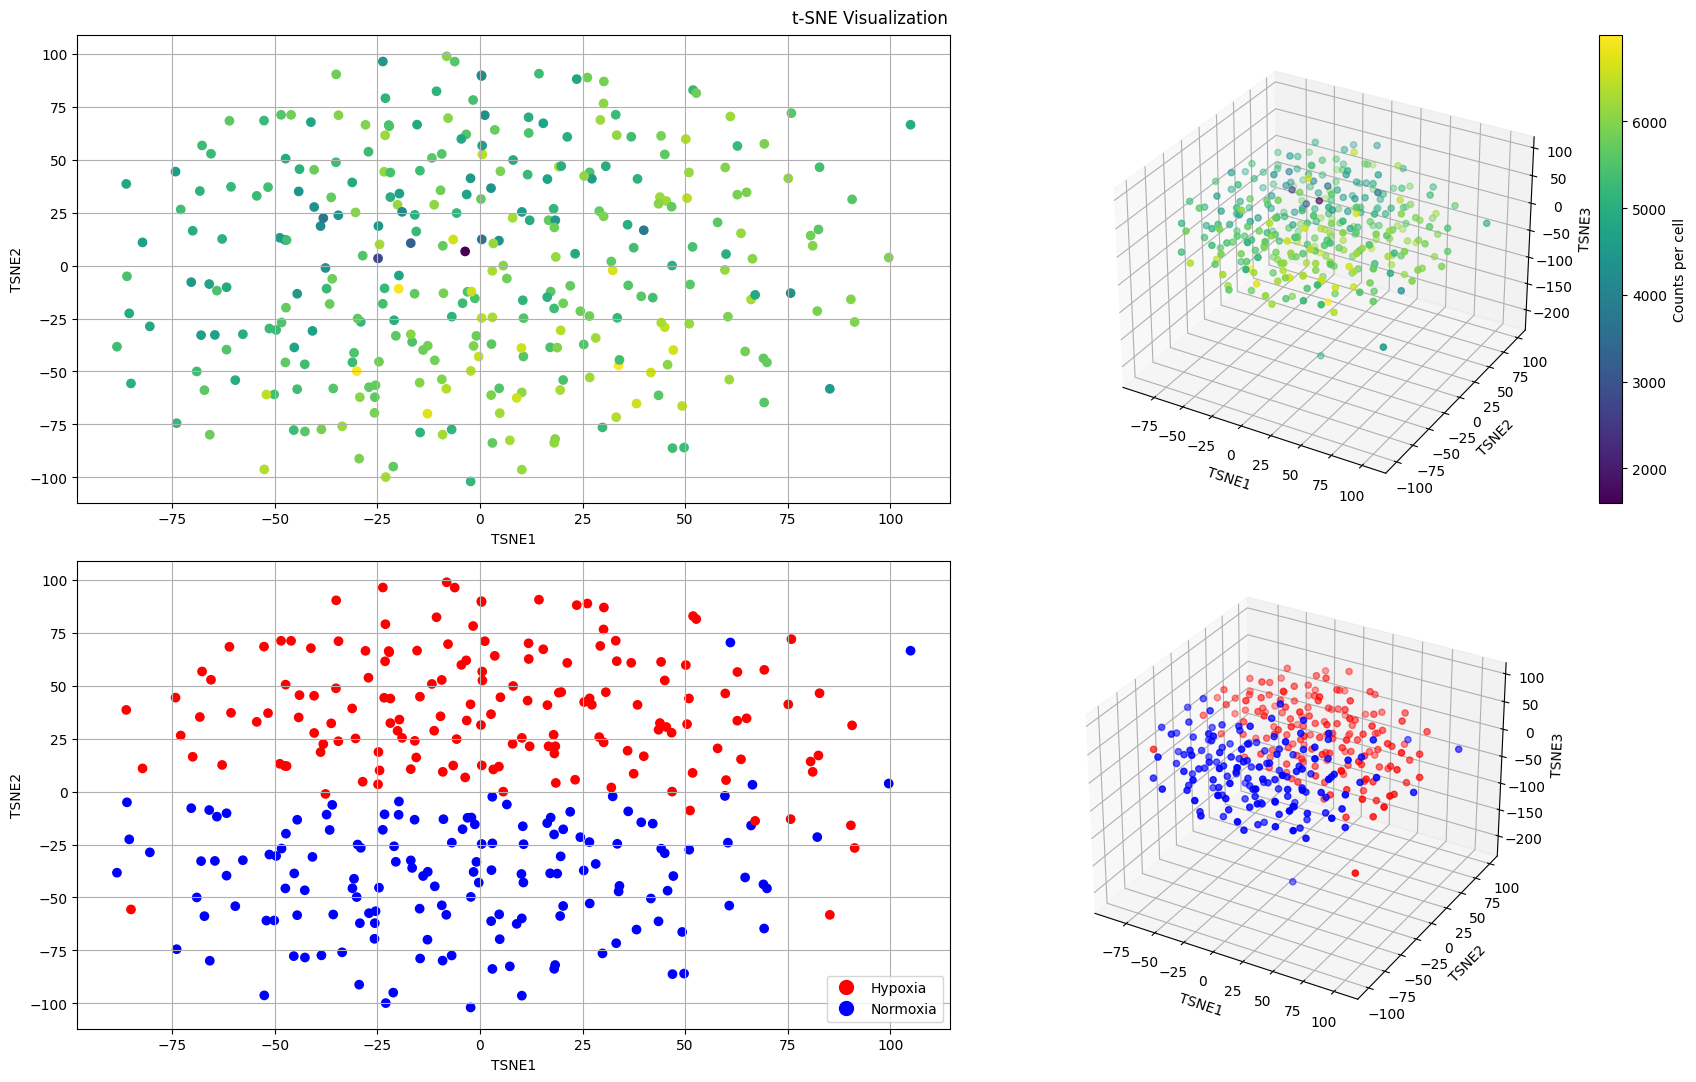

In [102]:
plot_dim_red("t-SNE", m_filtered_tsne, "TSNE1", "TSNE2", "TSNE3")
plt.show()

Again, a clear-cut cluster of hypoxic and normoxic cells is captured in this lower dimensional space. Notice that the fact that the clusters are close to each other, doesn't mean that they're similar, as the distance between clusters has no meaning in t-SNE.

### UMAP

In [103]:
# calculate UMAP projection
reducer = umap.UMAP(n_components=3)
h_umap = reducer.fit_transform(m_filtered_scaled)

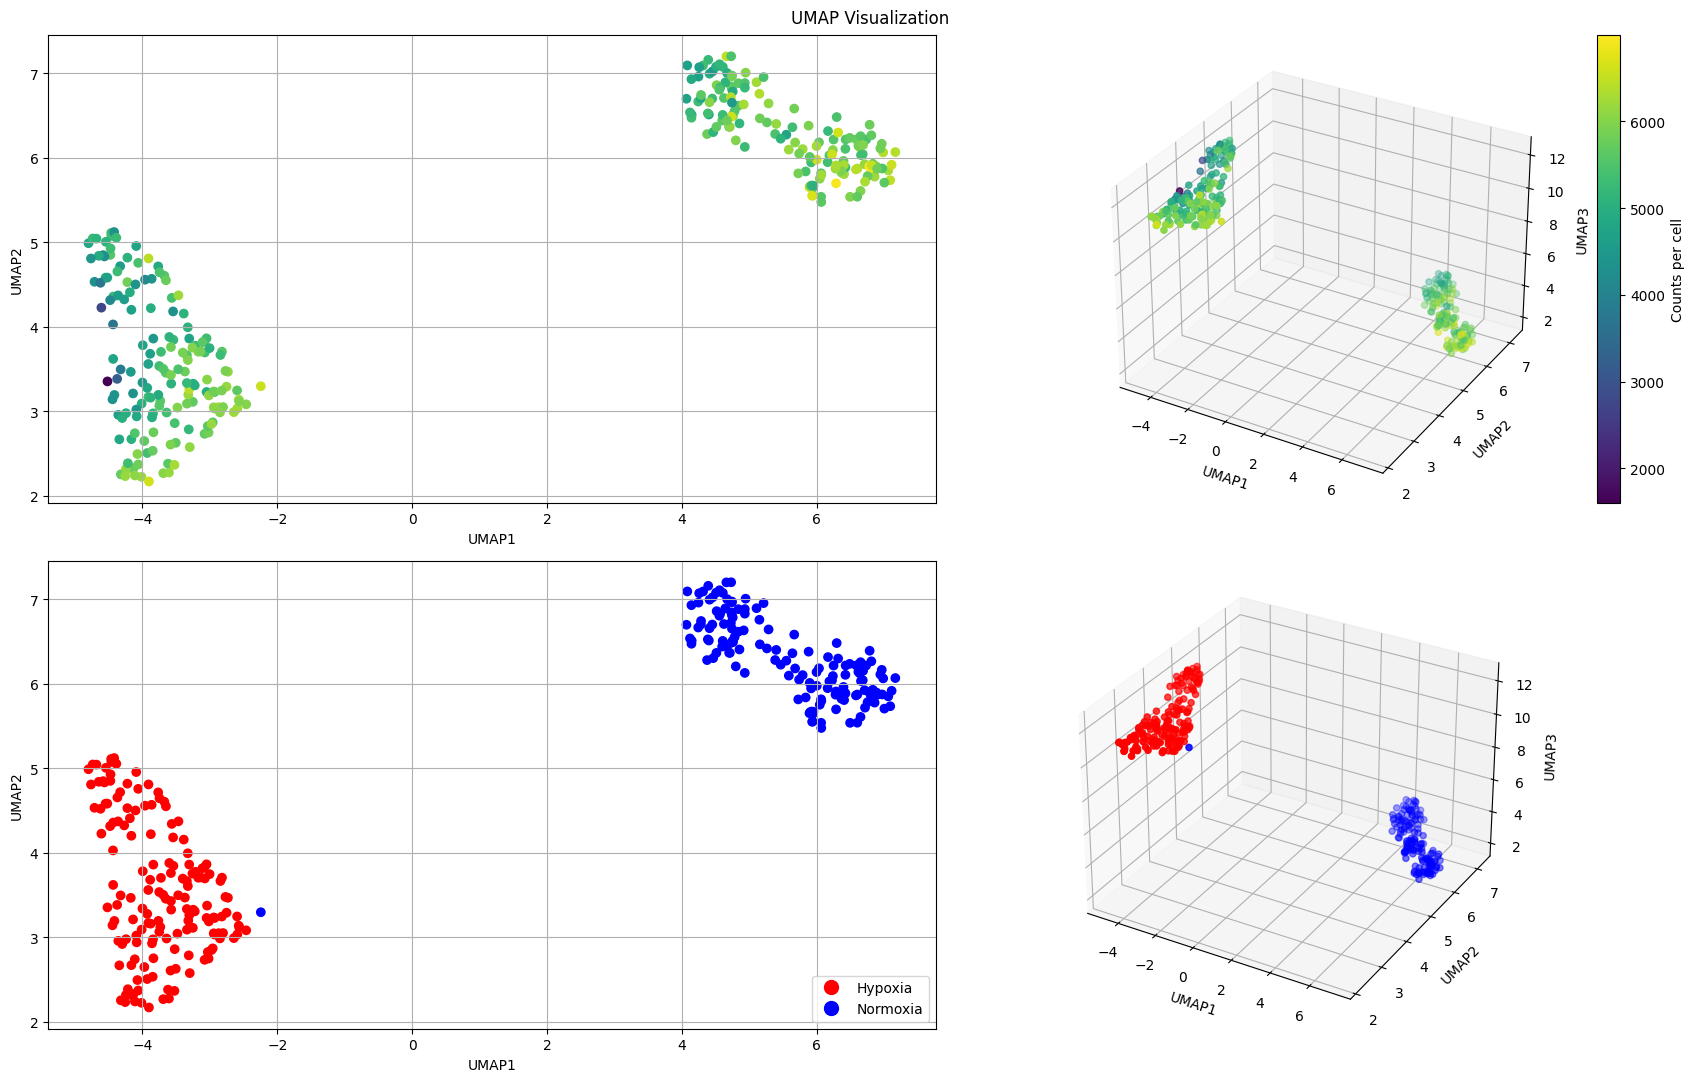

In [104]:
plot_dim_red("UMAP", h_umap, "UMAP1", "UMAP2", "UMAP3")
plt.show()

Here there's an evident separation. One interesting aspect is the presence of a normoxic cell in the hypoxic group, which hasn't really appeared before in t-SNE and PCA.

# **Downstream Analysis**

Now, we're seeking to gain an even deeper understading of the structure of the data. We'll procede both as follows:
- Correlation
- Unsupervised Clustering
  - Hierarchical
  - K-Means
  - Leiden Algorithm
- Gene Annotation

## Correlation

Just like we did in the EDA section, let's check again the correlation of this filtered data, as see if we can notice something different.

In [105]:
m_filtered = m_filtered.transpose()

We now want to check the correlation between samples and features. As before, we first proceed at looking at the correlation between samples. We are going to visualize both Pearson's and Spearman's rank correlation, but we are going to analyze only the former, not the latter. 

Average between minimum and maximum correlation:  0.620438272406192
Average correlation of expression profiles between cells:  0.5584439600596268
Min. correlation of expression profiles between cells:  0.24087654481238396


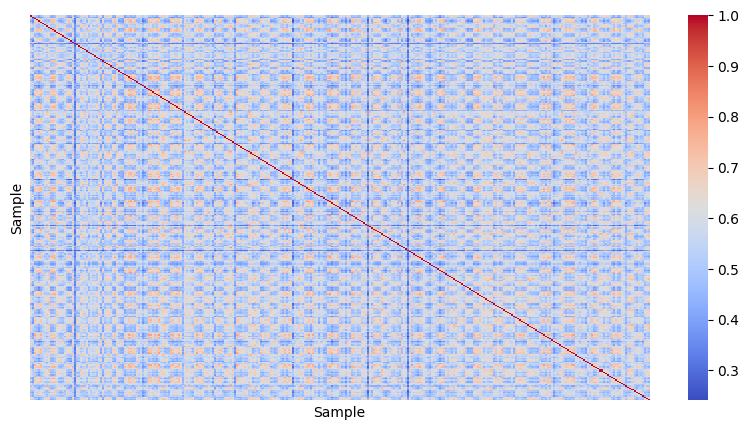

In [106]:
#pearson correlation coefficient
corr_matrix_p = m_filtered.corr(method = 'pearson')

average = (corr_matrix_p.values.max() - corr_matrix_p.values.min()) /2 + corr_matrix_p.values.min()
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_p.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_p.values.min())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_p, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Average between minimum and maximum correlation:  0.622196089841032
Average correlation of expression profiles between cells:  0.52205092818072
Min. correlation of expression profiles between cells:  0.24439217968206414


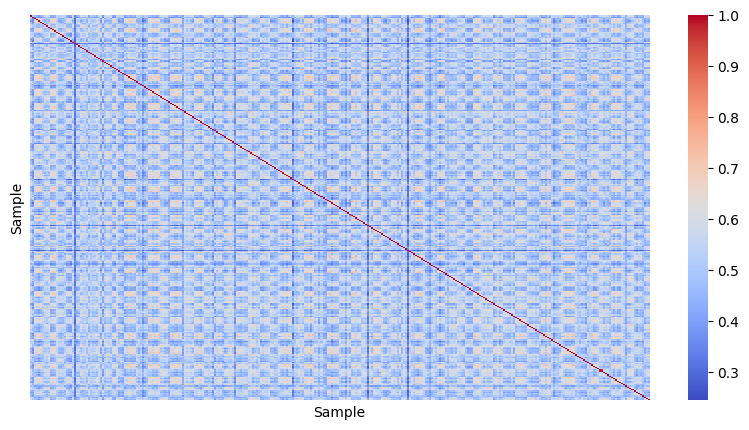

In [107]:
#spearman correlation coefficient
corr_matrix_s = m_filtered.corr(method = 'spearman')

average = (corr_matrix_s.values.max() - corr_matrix_s.values.min()) /2 + corr_matrix_s.values.min()
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_s.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_s.values.min())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_s, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Notice that there is a correlation between most cells. As before, let's plot the distribution of the correlation between gene expression profiles using a histogram (we do it on the first seven variables in order not to lose too much time). 

[]

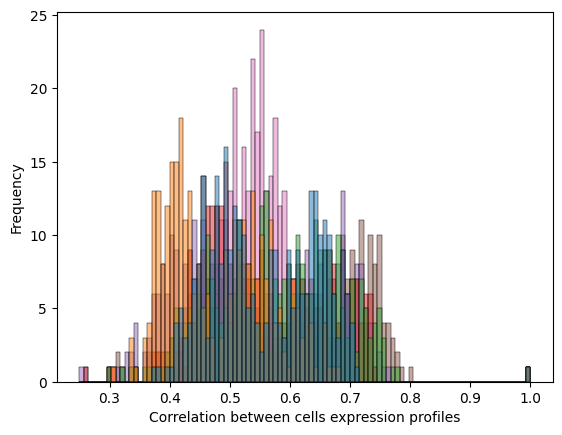

In [108]:
c = corr_matrix_p

c_small=corr_matrix_p.iloc[:,:7]
sns.histplot(c_small,bins=100)
plt.legend().set_visible(False);
plt.ylabel('Frequency')
plt.xlabel('Correlation between cells expression profiles')
plt.plot()

Notice that cells are correlated with others. 

Now, we want to focus on the distribution of cells that have a low correlation with all the others, in order to understand why this happens, and what are its properties. Let's look at their distribution. So, let's find the low and the highly correlated cells by analyzing the average correlation of a cell.

In [110]:
#find low and high correlated cells
correlation_threshold = 0.5

low_corr_cells = (corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) <= correlation_threshold
high_corr_cells = ((corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) > correlation_threshold) & ((corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) <= 0.6)
very_high_corr_cells = (corr_matrix_p.sum(axis = 0) / corr_matrix_p.shape[1] ) > 0.6

Now, let's analyse the distribution of the low correlated cells.

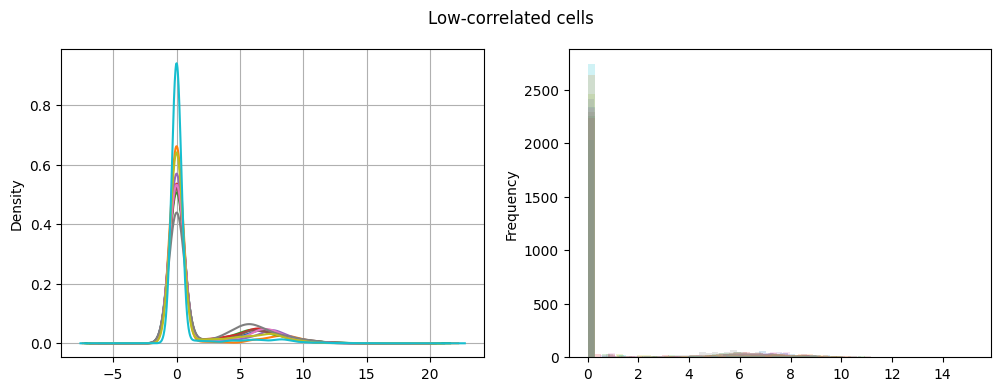

In [111]:
low_corr = m_filtered.loc[:, low_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("Low-correlated cells")
for s in low_corr.columns[:10]:
    low_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[0].set_ylabel("Density")
 
for s in low_corr.columns[:10]:
    ax[1].hist(low_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
ax[1].legend().set_visible(False)
plt.show()

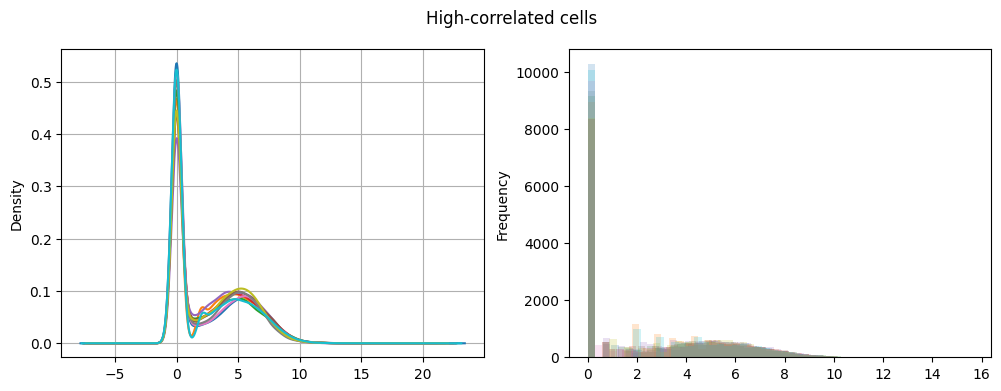

In [112]:
high_corr = m_unfiltered.loc[:, high_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("High-correlated cells")
for s in high_corr.columns[:10]:
    high_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[0].set_ylabel("Density")
 
for s in high_corr.columns[:10]:
    ax[1].hist(high_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
plt.show()

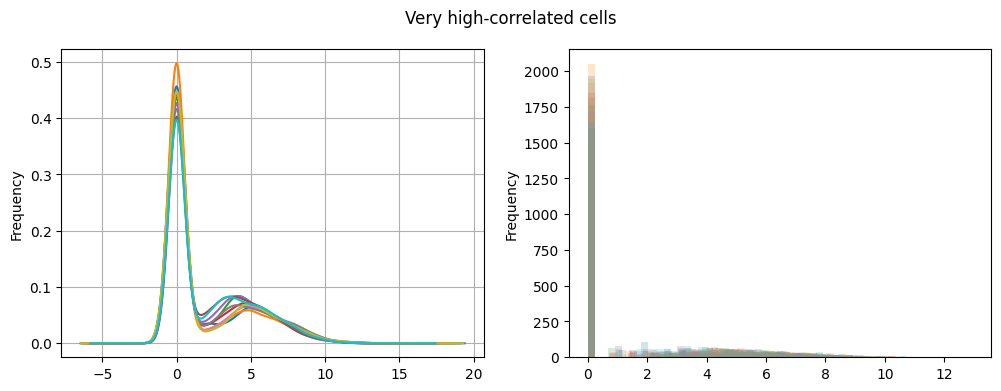

In [113]:
very_high_corr = m_filtered.loc[:, very_high_corr_cells]

# 10 densities
fig, ax = plt.subplots(1,2, figsize=(12,4))
plt.suptitle("Very high-correlated cells")
for s in very_high_corr.columns[:10]:
    very_high_corr[s].plot.density(legend = False, ax = ax[0])  
ax[0].grid(True)
ax[0].set_ylabel("Frequency")
 
for s in very_high_corr.columns[:10]:
    ax[1].hist(very_high_corr[s], bins = 50, alpha = 0.2)
ax[1].set_ylabel("Frequency")
plt.show()

From the distributions, we see that the distributions are fairly similar among low/high correlated samples. Let's check this: 

In [114]:
#max
print("Max expression low correlated cells: ", low_corr.max(axis = 0).max())
print("Max expression high correlated cells: ", high_corr.max(axis = 0).max())
print("Max expression very high correlated cells: ", very_high_corr.max(axis = 0).max())

Max expression low correlated cells:  15.163659901127222
Max expression high correlated cells:  16.949447887257374
Max expression very high correlated cells:  12.934327948183078


In [115]:
#average
print("Average expression low correlated cells: ", low_corr.mean().mean())
print("Average expression high correlated cells: ", high_corr.mean().mean())
print("Average expression very high correlated cells: ", very_high_corr.mean().mean())

Average expression low correlated cells:  1.3254321699494027
Average expression high correlated cells:  2.589482724695591
Average expression very high correlated cells:  2.027460147514538


In [116]:
#sparsity of low_corr, high_corr and very_high_corr
sparsity_index_low = 1 - (np.count_nonzero(low_corr.values) / low_corr.size)
sparsity_index_high = 1 - (np.count_nonzero(high_corr.values) / high_corr.size)
sparsity_index_very_high = 1 - (np.count_nonzero(very_high_corr.values) / very_high_corr.size)
print("Low correlation: ", sparsity_index_low)
print("High correlation: ", sparsity_index_high)
print("Very high correlation: ", sparsity_index_very_high)

Low correlation:  0.7848974358974359
High correlation:  0.4687505977753956
Very high correlation:  0.5906833333333333


The data displayed above confirm what was previously stated, indeed.

Now, we are interested in how hypoxic and normoxic cells relate to each other. So, we want to analyze, using the Pearson correlation coefficient, the correlation between hypoxic and normoxic cells between them.

Hypoxic:
Number of cells included:  (160, 160)
Average between minimum and maximum correlation:  0.6329223906691688
Average correlation of expression profiles between cells:  0.6004794153807913
Min. correlation of expression profiles between cells:  0.2658447813383376
Normoxic:
Number of cells included:  (149, 149)
Average between minimum and maximum correlation:  0.7126095411781288
Average correlation of expression profiles between cells:  0.6453142879759923
Min. correlation of expression profiles between cells:  0.42521908235625766
Mixed:
Number of cells included:  (149, 160)
Average between minimum and maximum correlation:  0.4820118235019101
Average correlation of expression profiles between cells:  0.49542559163905137
Min. correlation of expression profiles between cells:  0.24087654481238396


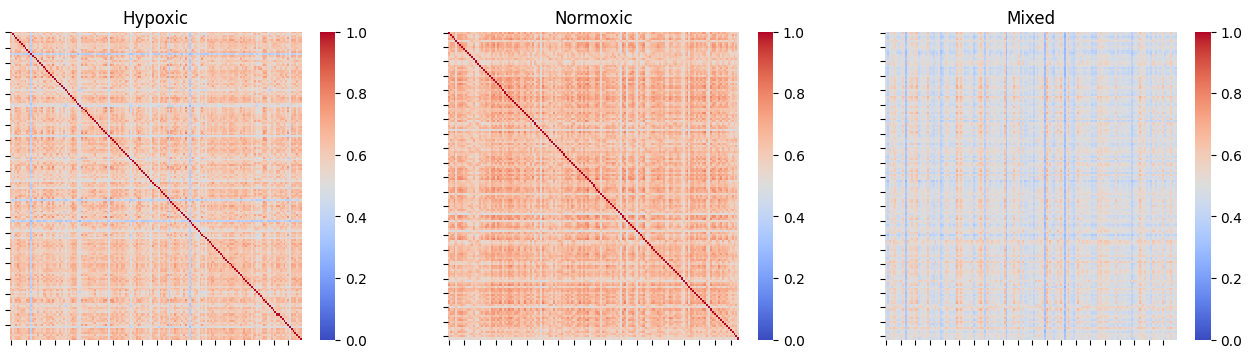

In [117]:
normoxic_cells = m_unfiltered.columns[m_filtered.columns.str.contains('Norm')].tolist()
hypoxic_cells = m_unfiltered.columns[m_filtered.columns.str.contains('Hypo')].tolist()

#correlation matrix between hypoxic cells
corr_matrix_hypoxic = corr_matrix_p.loc[hypoxic_cells, hypoxic_cells]
corr_matrix_hypoxic
print("Hypoxic:")
average = (corr_matrix_hypoxic.values.max() - corr_matrix_hypoxic.values.min()) /2 + corr_matrix_hypoxic.values.min()
print("Number of cells included: ", np.shape(corr_matrix_hypoxic))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_hypoxic.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_hypoxic.values.min())


#correlation matrix between normoxic cells
corr_matrix_normoxic = corr_matrix_p.loc[normoxic_cells, normoxic_cells]
corr_matrix_normoxic
print("Normoxic:")
average = (corr_matrix_normoxic.values.max() - corr_matrix_normoxic.values.min()) /2 + corr_matrix_normoxic.values.min()
print("Number of cells included: ", np.shape(corr_matrix_normoxic))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_normoxic.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_normoxic.values.min())

#correlation matrix between mixed cells
corr_matrix_mixed = corr_matrix_p.loc[normoxic_cells, hypoxic_cells]
corr_matrix_mixed
print("Mixed:")
average = (corr_matrix_mixed.values.max() - corr_matrix_mixed.values.min()) /2 + corr_matrix_mixed.values.min()
print("Number of cells included: ", np.shape(corr_matrix_mixed))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_mixed.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_mixed.values.min())

#Statistics:
fig, ax =plt.subplots(1,3, figsize = (16,4))

sns.heatmap(corr_matrix_hypoxic, cmap='coolwarm', ax=ax[0], vmin=0, vmax=1)
ax[0].set(title='Hypoxic', xticklabels=[], yticklabels=[])

sns.heatmap(corr_matrix_normoxic, cmap='coolwarm', ax=ax[1], vmin=0, vmax=1)
ax[1].set(title='Normoxic', xticklabels=[], yticklabels=[])

sns.heatmap(corr_matrix_mixed, cmap='coolwarm', ax=ax[2], vmin=0, vmax=1)
ax[2].set(title='Mixed', xticklabels=[], yticklabels=[])

plt.show()


Notice that mixed cells don't seem to be very much correlated between them. Instead, for normoxic and hypoxic cells no particular patterns emerge.

Now we are interested in the analysis of the correlation of genes. Let's first use again Pearson and Spearman correlation coefficients.

In [118]:
#pearson correlation coefficient
corr_matrix_p = m_filtered.transpose().corr(method = 'pearson')

average = (corr_matrix_p.values.max() - corr_matrix_p.values.min()) /2 + corr_matrix_p.values.min()
print("Number of cells included: ", np.shape(corr_matrix_p))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_p.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_p.values.min())

plt.figure(figsize=(30,15))
sns.heatmap(corr_matrix_p, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Number of cells included:  (3000, 3000)
Average between minimum and maximum correlation:  0.09766515475180049
Average correlation of expression profiles between cells:  0.01180812603054901
Min. correlation of expression profiles between cells:  -0.7588024909042175


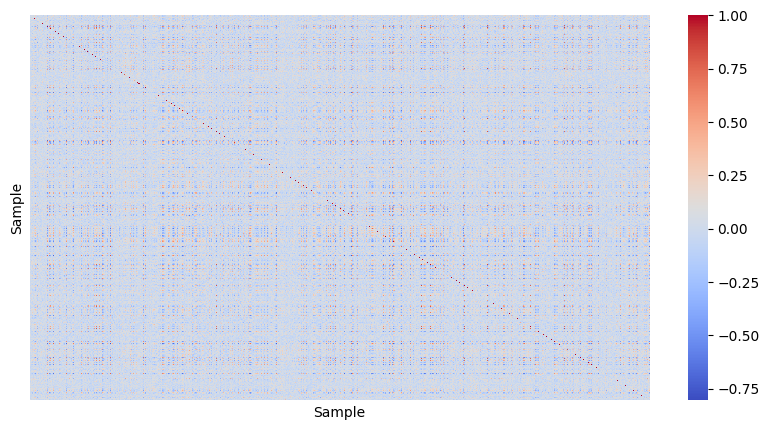

In [119]:
#spearman correlation coefficient
corr_matrix_s = m_filtered.transpose().corr(method = 'spearman')

average = (corr_matrix_s.values.max() - corr_matrix_s.values.min()) /2 + corr_matrix_s.values.min()
print("Number of cells included: ", np.shape(corr_matrix_s))
print("Average between minimum and maximum correlation: ", average)
print("Average correlation of expression profiles between cells: ", corr_matrix_p.mean().mean())
print("Min. correlation of expression profiles between cells: ", corr_matrix_p.values.min())

plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix_s, cmap='coolwarm', yticklabels = False, xticklabels = False)
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.show()

Notice that overall there doesn't seem to be some significant structure of genes. Indeed most are not correlated and that's it.

To go on with this analysis, we can also proceed by creating a co-expression network.

In [120]:
corr_threshold = 0.45
adj_corr_matrix = np.abs(corr_matrix_p) > corr_threshold
adj_corr_matrix = adj_corr_matrix.astype(int)
adj_corr_matrix

#remove diagonal
n = adj_corr_matrix.shape[0]
diagonal = pd.DataFrame(0, index=adj_corr_matrix.index, columns=adj_corr_matrix.columns)

# set diagonal elements to 1
for i in range(n):
    diagonal.iloc[i,i] = 1

adj_corr_matrix = adj_corr_matrix - diagonal
adj_corr_matrix

genes_to_keep = adj_corr_matrix.sum() != 0
adj_corr_matrix = adj_corr_matrix.loc[genes_to_keep,genes_to_keep]
adj_corr_matrix

LINC01770  CFAP74  ERRFI1  LINC01714  DHRS3  ATP13A2  IFFO2  PINK1  \
LINC01770          0       0       0          0      0        0      0      0   
CFAP74             0       0       0          0      0        0      0      0   
ERRFI1             0       0       0          0      0        0      0      0   
LINC01714          0       0       0          0      0        0      0      0   
DHRS3              0       0       0          0      0        0      0      0   
...              ...     ...     ...        ...    ...      ...    ...    ...   
TFF1               0       0       0          0      0        0      0      0   
AATBC              0       0       0          0      0        0      0      0   
COL18A1            0       0       0          0      0        0      0      0   
FTCD               0       0       0          0      0        0      0      0   
LSS                0       0       0          0      0        1      1      0   

           PINK1-AS  EPHA8  ...  DSCAM  DSCAM-AS1  BACE2  ZBTB21  TFF3  TFF1  \
LINC01770         0      0  ...      0          0      0       0     0     0   
CFAP74            0      0  ...      0          0      0       0     0     0   
ERRFI1            0      0  ...      0          1      0       0     0     0   
LINC01714         0      0  ...      0          0      0       0     0     0   
DHRS3             0      0  ...      0          0      0       0     0     0   
...             ...    ...  ...    ...        ...    ...     ...   ...   ...   
TFF1              0      0  ...      0          0      0       0     1     0   
AATBC             0      0  ...      0          0      0       0     0     0   
COL18A1           0      0  ...      0          0      0       0     0     0   
FTCD              0      0  ...      0          0      0       0     0     0   
LSS               0      0  ...      1          1      0       0     0     0   

           AATBC  COL18A1  FTCD  LSS  
LINC01770      0        0     0    0  
CFAP74         0        0     0    0  
ERRFI1         0        0     0    0  
LINC01714      0        0     0    0  
DHRS3          0        0     0    0  
...          ...      ...   ...  ...  
TFF1           0        0     0    0  
AATBC          0        0     0    0  
COL18A1        0        0     0    1  
FTCD           0        0     0    0  
LSS            0        1     0    0  

[969 rows x 969 columns]

Here the code to have the html file, named "graph_output_MCF7"
To draw it we'll create an HTML file that will output an interactive plot, in which one will be able to see which genes have an edge to each other.
Since loading will take time, we also put a simple plot generated with python, to avoid the burdens of waiting for the loading of the HTML file.

In [121]:
def draw_graph3(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=False,only_physics_buttons=False):
        """
        This function accepts a networkx graph object,
        converts it to a pyvis network object preserving its node and edge attributes,
        and both returns and saves a dynamic network visualization.

        Valid node attributes include:
            "size", "value", "title", "x", "y", "label", "color".

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)

        Valid edge attributes include:
            "arrowStrikethrough", "hidden", "physics", "title", "value", "width"

            (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)


        Args:
            networkx_graph: The graph to convert and display
            notebook: Display in Jupyter?
            output_filename: Where to save the converted network
            show_buttons: Show buttons in saved version of network?
            only_physics_buttons: Show only buttons controlling physics of network?
        """

        # import
        from pyvis import network as net

        # make a pyvis network
        pyvis_graph = net.Network(notebook=notebook, cdn_resources='in_line')
        pyvis_graph.width = '1000px'
        # for each node and its attributes in the networkx graph
        for node,node_attrs in networkx_graph.nodes(data=True):
            pyvis_graph.add_node(node,**node_attrs)
    #         print(node,node_attrs)

        # for each edge and its attributes in the networkx graph
        for source,target,edge_attrs in networkx_graph.edges(data=True):
            # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
            if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
                # place at key 'value' the weight of the edge
                edge_attrs['value']=edge_attrs['weight']
            # add the edge
            pyvis_graph.add_edge(source,target,**edge_attrs)

        # turn buttons on
        if show_buttons:
            if only_physics_buttons:
                pyvis_graph.show_buttons(filter_=['physics'])
            else:
                pyvis_graph.show_buttons()

        # return and also save
        pyvis_graph.save_graph(output_filename)
        return pyvis_graph.show(output_filename)

graph = nx.from_pandas_adjacency(adj_corr_matrix, create_using=None)
draw_graph3(graph,output_filename='graph_output_MCF7.html', notebook=True)


graph_output_MCF7.html


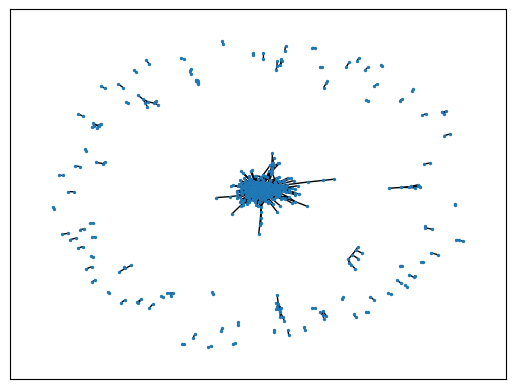

In [122]:
graph = nx.from_pandas_adjacency(adj_corr_matrix, create_using=None)
layout = nx.spring_layout(graph) #kamada_kawai
nx.draw_networkx(graph, pos = layout, node_size = 2, with_labels = False)
plt.show()

In both cases, we see clusters of highly correlated genes, so some intrinsic structure exits.

## Unsupervised Clustering

Here we want to group cells, without any prior knowledge, based on similarity conditions, which we'll define via distance metrics. We'll then visualize the cluster on a lower dimensional space using the techniques of the Dimensionality Reduction section.

We'll apply the following methods:
- Hierarchical Clustering
- K-Means Clustering
- Leiden Clustering

### Hierarchical

Let's do hierachical clustering, using four linkage methods: complete, average, Ward annd median.

In [123]:
hierarchical = m_filtered.transpose() # genes as column
hierarchical.shape

(309, 3000)

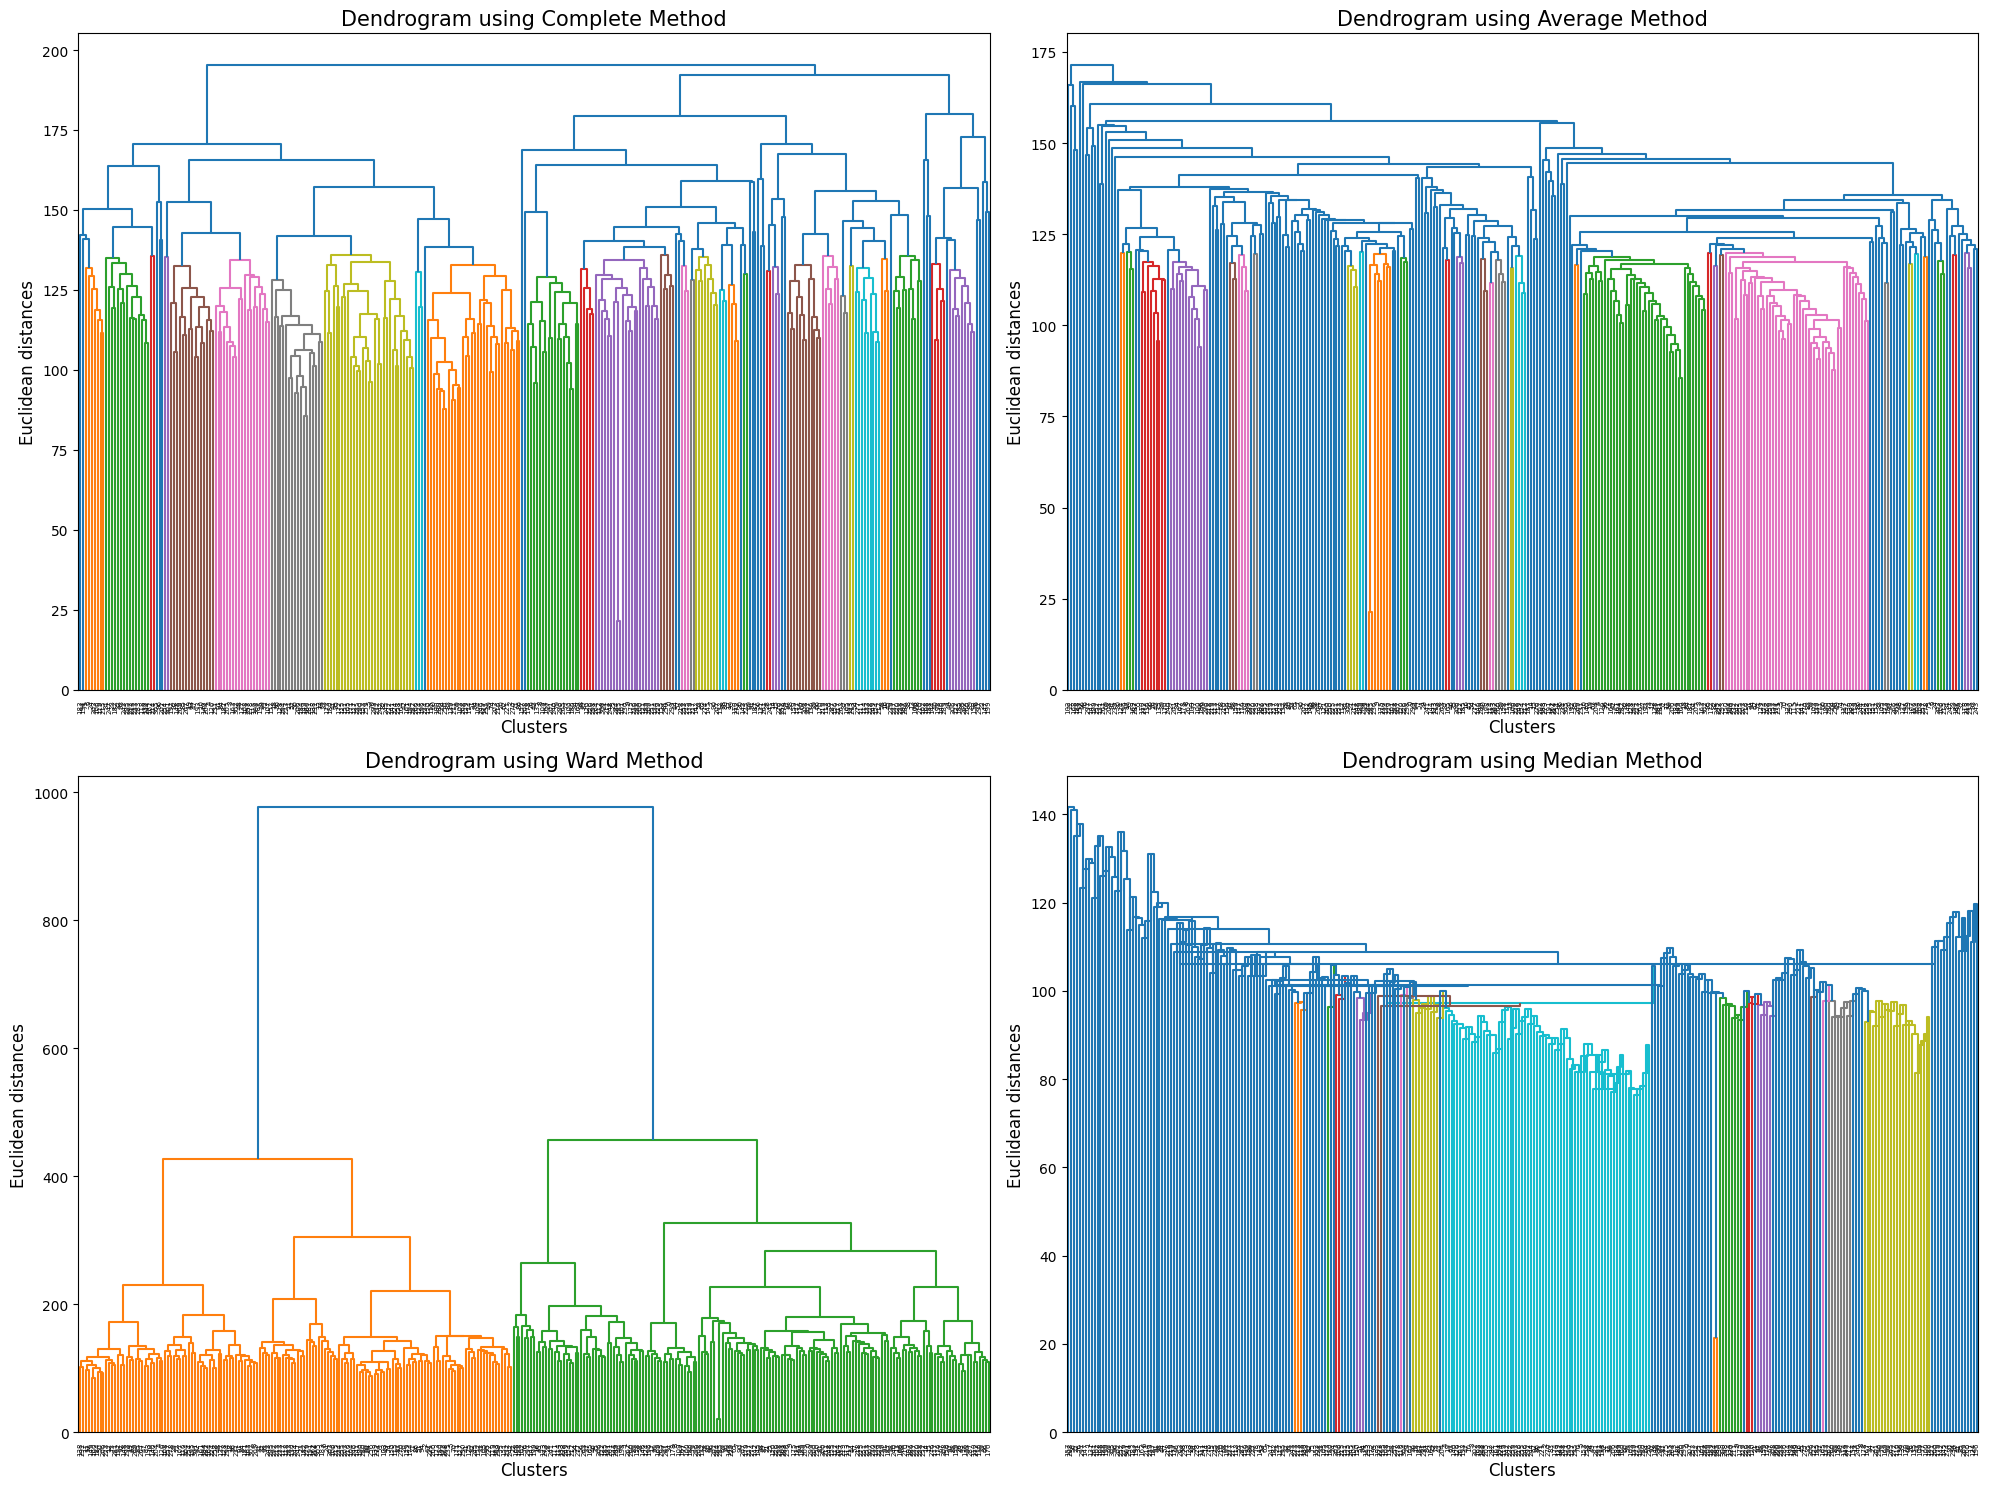

In [124]:
linkage_methods = ['complete', 'average', 'ward', 'median']

# Loop through the linkage methods and plot each dendrogram subplot
fig, axs = plt.subplots(len(linkage_methods)//2, 2, figsize=(20, 15))

# Loop through the linkage methods and plot each dendrogram subplot
for i, method in enumerate(linkage_methods):
    row = i // 2
    col = i % 2
    dend = dendrogram(linkage(hierarchical, method=method), ax=axs[row, col])
    axs[row, col].set_title(f"Dendrogram using {method.capitalize()} Method", fontsize=15)
    axs[row, col].set_xlabel('Clusters', fontsize=12)
    axs[row, col].set_ylabel('Euclidean distances', fontsize=12)
    axs[row, col].grid(False)

# Adjust the spacing between subplots and display the figure
fig.tight_layout()
plt.show()

Notice that the only structure that seems relevant is the one obtained using the Ward Method. In fact, there are 2 distinct clusters that emerge, and they could be clearly the hypoxic and the normoxic cells.

### K-Means

Let's now run k-means.

In [125]:
kmeans_df = m_filtered.transpose()

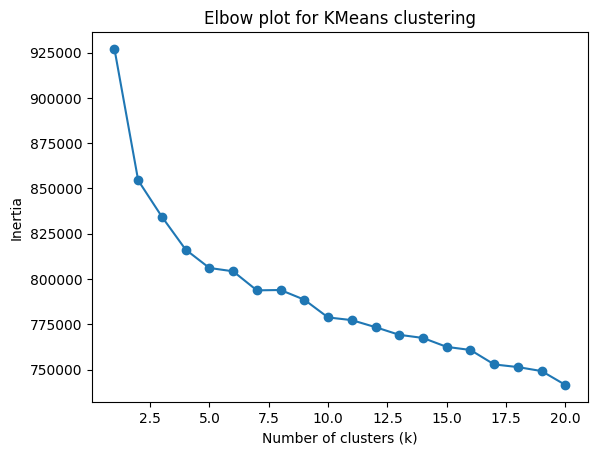

In [126]:
k_range = range(1, 21)

inertia = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(StandardScaler().fit_transform(kmeans_df))
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow plot for KMeans clustering')
plt.show()

Again, there's no true elbow, so the optimal number of clusters may vary. Let's now visualize the clusters, using a PCA projection.

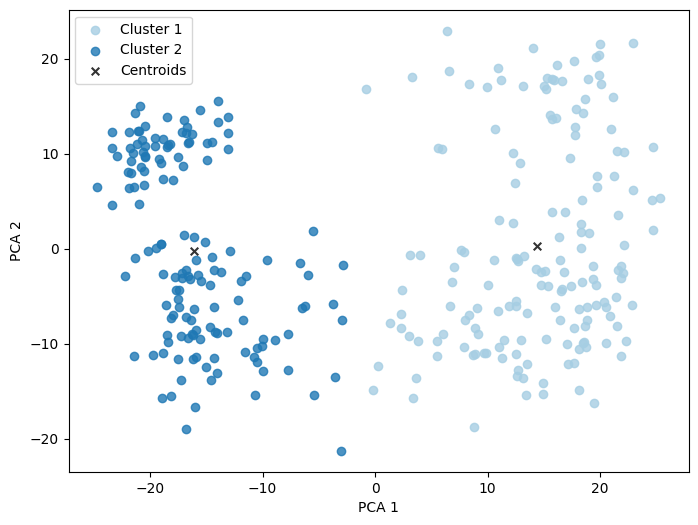

In [127]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
pca = PCA(n_components=2)
PCA_components = pca.fit_transform(StandardScaler().fit_transform(kmeans_df))
kmeans.fit(PCA_components)
cluster_labels = kmeans.predict(PCA_components)
centroids = kmeans.cluster_centers_
kmeans_df['cluster'] = cluster_labels
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("Paired", n_colors=4)
for i in range(2):
    ax.scatter(PCA_components[kmeans_df['cluster']==i, 0], PCA_components[kmeans_df['cluster']==i, 1], alpha=0.8, label='Cluster '+str(i+1), color=colors[i])
ax.scatter(centroids[:,0], centroids[:,1], marker='x', s=30, color='black', alpha = 0.8, label='Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
ax.legend()
plt.show()

From 2 clusters we see a clear distinction between hypoxic and normoxic cells. Let's also try with 4 clusters.

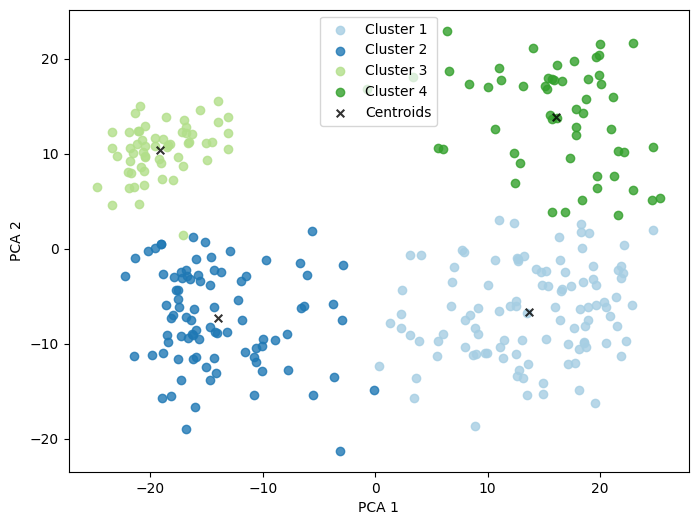

In [128]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
pca = PCA(n_components=2)
PCA_components = pca.fit_transform(StandardScaler().fit_transform(kmeans_df))
kmeans.fit(PCA_components)
cluster_labels = kmeans.predict(PCA_components)
centroids = kmeans.cluster_centers_
kmeans_df['cluster'] = cluster_labels
fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("Paired", n_colors=4)
for i in range(4):
    ax.scatter(PCA_components[kmeans_df['cluster']==i, 0], PCA_components[kmeans_df['cluster']==i, 1], alpha=0.8, label='Cluster '+str(i+1), color=colors[i])
ax.scatter(centroids[:,0], centroids[:,1], marker='x', s=30, color='black', alpha = 0.8, label='Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
ax.legend()
plt.show()

In the case of 4 clusters, instead, we see the presence of two upper subclusters, which are separated even visually in the PCA projection.

### Leiden Clustering Technique

Let's implement Leiden's algorithm

In [129]:
sc.settings.verbosity = 0
leiden = m_filtered.transpose()
adata = sc.AnnData(leiden.copy())

Now some preliminary necessary procedures to run the algorithm

In [130]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
sc.pp.scale(adata)
sc.pp.pca(adata, svd_solver="arpack", n_comps = 277) # same plot as before
sc.pp.neighbors(adata, n_pcs = 242) # computes the KNN graph on the lower-dim space on 242 components (95% variance)

We are now ready to apply the Leiden algorithm

In [131]:
sc.tl.leiden(adata)

Let's use the same resolution parameters applied in the other cell line.

In [132]:
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res0_6", resolution=0.6)
sc.tl.leiden(adata, key_added="leiden_res0_7", resolution=0.7)
sc.tl.leiden(adata, key_added="leiden_res0_8", resolution=0.8)
sc.tl.leiden(adata, key_added="leiden_res0_9", resolution=0.9)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

Let's plot the Leiden clusters on the 2D PCA projection.

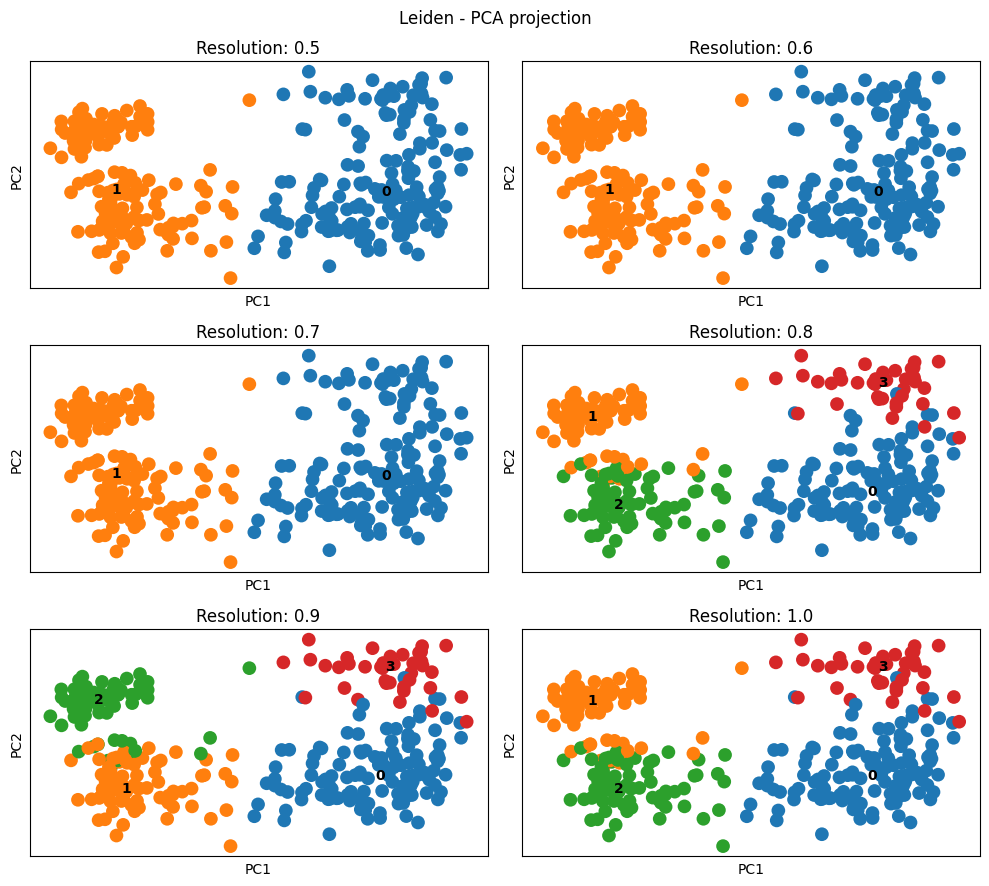

In [133]:
fig, axs = plt.subplots(3, 2, figsize=(10, 9))
plt.suptitle("Leiden - PCA projection")

sc.pl.pca(adata, color="leiden_res0_5", legend_loc="on data", ax=axs[0, 0], show=False)
axs[0, 0].set_title("Resolution: 0.5")

sc.pl.pca(adata, color="leiden_res0_6", legend_loc="on data", ax=axs[0, 1], show=False)
axs[0, 1].set_title("Resolution: 0.6")

sc.pl.pca(adata, color="leiden_res0_7", legend_loc="on data", ax=axs[1, 0], show=False)
axs[1, 0].set_title("Resolution: 0.7")

sc.pl.pca(adata, color="leiden_res0_8", legend_loc="on data", ax=axs[1, 1], show=False)
axs[1, 1].set_title("Resolution: 0.8")

sc.pl.pca(adata, color="leiden_res0_9", legend_loc="on data", ax=axs[2, 0], show=False)
axs[2, 0].set_title("Resolution: 0.9")

sc.pl.pca(adata, color="leiden_res1", legend_loc="on data", ax=axs[2, 1], show=False)
axs[2, 1].set_title("Resolution: 1.0")

plt.tight_layout()
plt.show()

Resolutions 0.5, 0.6, and 0.7 all find two clusters, which correspond to the hypoxia-normoxia separation. Later, higher resolutions find other subclusters.
In addition, the clusters seem similar to those found in k-means.

For our classification purposes, 0.7 seems the ideal value, but 0.9 still remains interesting as it captures subclusters.

## Gene Annotation

Now let's label groups of cells based on the same given markers of the HCC1806 cell line. Recall that we're not dealing with different cell-types. This gives just an intuition about what might be genetic differences between hypoxic and normoxic cells.

First, in spirit to the EDA section, let's check which genes are produced the most by each cell, and for normoxic and hypoxic cells, check the top 5 expressed genes.

In [134]:
# which gene are produced the most by each cell
print(pd.DataFrame({'gene': m_filtered.idxmax(), 'value': m_filtered.max()}))
print("Uniques[{}]: {}".format(m_filtered.idxmax().unique().size, m_filtered.idxmax().unique()))

                                                        gene      value
output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoor...     DDIT4  12.471898
output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoor...     DDIT4  14.075884
output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord....      TFF1  12.721835
output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord....  SLC9A3R1  12.219256
output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord....      CTSD  11.880306
...                                                      ...        ...
output.STAR.4_H5_Norm_S359_Aligned.sortedByCoor...     NR4A1  11.599893
output.STAR.4_H6_Norm_S360_Aligned.sortedByCoor...      XBP1  11.756792
output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoor...    CYP1B1  14.815866
output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoor...    CYP1B1  14.029044
output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoor...       GPI  13.502424

[309 rows x 2 columns]
Uniques[38]: ['DDIT4' 'TFF1' 'SLC9A3R1' 'CTSD' 'CYP1B1' 'TUBA1B' 'CYP1A1' 'FOS' 'COX6C'
 'UBB' 'DHCR7' 'UBC' 'GP

So, 309 cells expressed mostly 38 main genes.

In [135]:
# check for normoxic, hypoxic cells which are the top 10 expressed genes
print("Top 5 genes of normoxic cells:\n", m_filtered.loc[:, normoxic_cells].sum(axis = 1).nlargest(5))
print("Top 5 genes of hypoxic cells:\n", m_filtered.loc[:, hypoxic_cells].sum(axis = 1).nlargest(5))

Top 5 genes of normoxic cells:
 CTSD        1602.668814
SLC9A3R1    1571.288571
UBC         1527.902334
TUBA1B      1524.679833
SCD         1514.835658
dtype: float64
Top 5 genes of hypoxic cells:
 CYP1B1        1974.200892
GPI           1961.123482
UBC           1944.037182
DDIT4         1860.612171
CYP1B1-AS1    1765.444244
dtype: float64


Now let's identify the markers, using the same techniques as in the other cell line.

In [136]:
marker_genes = {
    #these one are standard
    "CD14+ Mono": ["FCN1", "CD14"],
    "CD16+ Mono": ["TCF7L2", "FCGR3A", "LYN"],
    "ID2-hi myeloid prog": [
        "CD14",
        "ID2",
        "VCAN",
        "S100A9",
        "CLEC12A",
        "KLF4",
        "PLAUR",
    ],
    "cDC1": ["CLEC9A", "CADM1"],
    "cDC2": [
        "CST3",
        "COTL1",
        "LYZ",
        "DMXL2",
        "CLEC10A",
        "FCER1A",
    ],  # Note: DMXL2 should be negative
    "Normoblast": ["SLC4A1", "SLC25A37", "HBB", "HBA2", "HBA1", "TFRC"],
    "Erythroblast": ["MKI67", "HBA1", "HBB"],
    "Proerythroblast": [
        "CDK6",
        "SYNGR1",
        "HBM",
        "GYPA",
    ],  # Note HBM and GYPA are negative markers
    "NK": ["GNLY", "NKG7", "CD247", "GRIK4", "FCER1G", "TYROBP", "KLRG1", "FCGR3A"],
    "ILC": ["ID2", "PLCG2", "GNLY", "SYNE1"],
    "Lymph prog": [
        "VPREB1",
        "MME",
        "EBF1",
        "SSBP2",
        "BACH2",
        "CD79B",
        "IGHM",
        "PAX5",
        "PRKCE",
        "DNTT",
        "IGLL1",
    ],
    "Naive CD20+ B": ["MS4A1", "IL4R", "IGHD", "FCRL1", "IGHM"],
    "B1 B": [
        "MS4A1",
        "SSPN",
        "ITGB1",
        "EPHA4",
        "COL4A4",
        "PRDM1",
        "IRF4",
        "CD38",
        "XBP1",
        "PAX5",
        "BCL11A",
        "BLK",
        "IGHD",
        "IGHM",
        "ZNF215",
    ],  # Note IGHD and IGHM are negative markers
    "Transitional B": ["MME", "CD38", "CD24", "ACSM3", "MSI2"],
    "Plasma cells": ["MZB1", "HSP90B1", "FNDC3B", "PRDM1", "IGKC", "JCHAIN"],
    "Plasmablast": ["XBP1", "RF4", "PRDM1", "PAX5"],  # Note PAX5 is a negative marker
    "CD4+ T activated": ["CD4", "IL7R", "TRBC2", "ITGB1"],
    "CD4+ T naive": ["CD4", "IL7R", "TRBC2", "CCR7"],
    "CD8+ T": ["CD8A", "CD8B", "GZMK", "GZMA", "CCL5", "GZMB", "GZMH", "GZMA"],
    "T activation": ["CD69", "CD38"],  # CD69 much better marker!
    "T naive": ["LEF1", "CCR7", "TCF7"],
    "pDC": ["GZMB", "IL3RA", "COBLL1", "TCF4"],
    "G/M prog": ["MPO", "BCL2", "KCNQ5", "CSF3R"],
    "HSC": ["NRIP1", "MECOM", "PROM1", "NKAIN2", "CD34"],
    "MK/E prog": [
        "ZNF385D",
        "ITGA2B",
        "RYR3",
        "PLCB1",
    ],  # Note PLCB1 is a negative marker
    # these ones are based on Peng-Ju et al., 2020, https://www.frontiersin.org/articles/10.3389/fonc.2020.579868 
    'Endothelial cells': ['VEGFA', 'SLC2A1', 'PGAM1', 'LDHA'],
    'Fibroblasts': ['TPI1', 'P4HA1', 'MRPS17', 'CDKN3'],
    'Adipocytes': ['ADM', 'NDRG1', 'TUBB6'],
    'Myocytes': ['ALDOA', 'MIF']
}

In [137]:
marker_genes_in_data = {}
for ct, markers in marker_genes.items():
    markers_found = list()
    for marker in markers:
        if marker in adata.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found
marker_genes_in_data = {k: v for k, v in marker_genes_in_data.items() if v} # keep nonempty sets

In [138]:
marker_genes_in_data

{'CD14+ Mono': ['CD14'],
 'CD16+ Mono': ['LYN'],
 'ID2-hi myeloid prog': ['CD14', 'ID2', 'S100A9', 'KLF4', 'PLAUR'],
 'cDC1': ['CADM1'],
 'cDC2': ['COTL1'],
 'Erythroblast': ['MKI67'],
 'NK': ['GRIK4'],
 'ILC': ['ID2', 'SYNE1'],
 'Lymph prog': ['MME', 'BACH2'],
 'B1 B': ['ITGB1', 'EPHA4', 'COL4A4', 'PRDM1', 'XBP1'],
 'Transitional B': ['MME'],
 'Plasma cells': ['FNDC3B', 'PRDM1'],
 'Plasmablast': ['XBP1', 'PRDM1'],
 'CD4+ T activated': ['ITGB1'],
 'CD4+ T naive': ['CCR7'],
 'T naive': ['CCR7', 'TCF7'],
 'HSC': ['MECOM'],
 'MK/E prog': ['ITGA2B'],
 'Endothelial cells': ['VEGFA', 'SLC2A1'],
 'Fibroblasts': ['P4HA1', 'CDKN3'],
 'Adipocytes': ['ADM', 'NDRG1']}

In [139]:
# subtypes we want to show the markers for
cell_subtypes = ["CD14+ Mono", "CD16+ Mono", "ID2-hi myeloid prog", "cDC1",
                 "cDC2", "Erythroblast", "NK", "ILC", "Lymph prog", "B1 B",
                 "Transitional B", "Plasma cells", "Plasmablast",
                 "CD4+ T activated", "CD4+ T naive", "T naive", "HSC",
                 "MK/E prog", "Endothelial cells", "Fibroblasts", "Adipocytes"]


In [140]:
for ct in cell_subtypes:
    print(f"{ct.upper()}:")
    sc.pl.pca(
        adata,
        color=marker_genes_in_data[ct],
        vmin=0,
        vmax="p99",  # set vmax to the 99th percentile of the gene count instead of the maximum
        sort_order=False,
        frameon=False,
        cmap="Reds")
    print("\n\n\n")

Output hidden; open in https://colab.research.google.com to view.

From the above plots, we see which how marker genes are expressed in different cells. Some structure seems to emerge.

Let's use Leiden with resolutions 0.7. First, we plot it once again, for illustration purposes.

<Axes: title={'center': 'leiden_res0_7'}, xlabel='PC1', ylabel='PC2'>

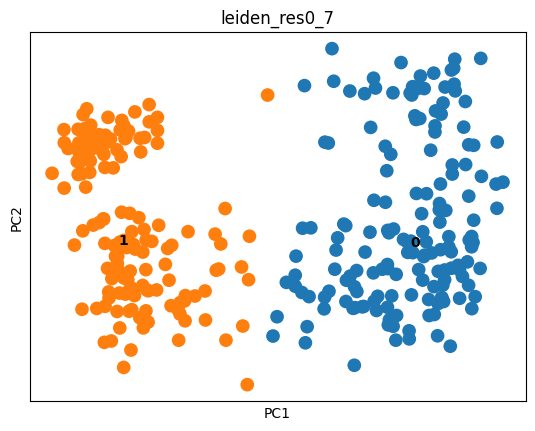

In [141]:
sc.pl.pca(adata, color="leiden_res0_7", legend_loc="on data", show=False)

Let's now do the dotplot, for both resolutions.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


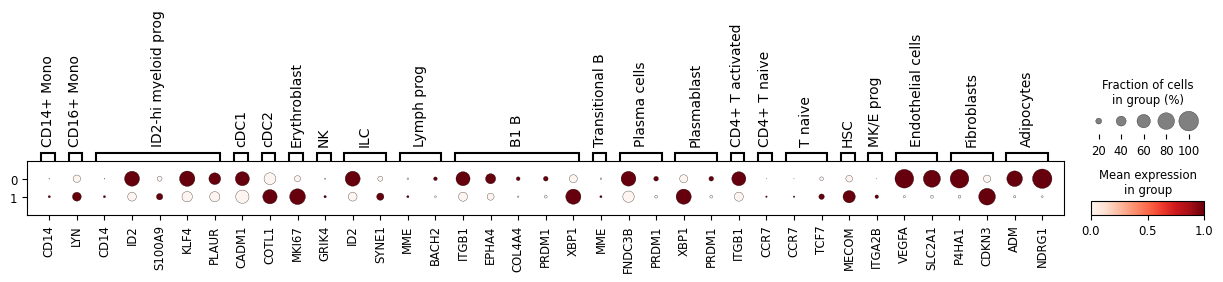

In [142]:
cell_markers = {
    ct: [m for m in ct_markers if m in adata.var.index]
    for ct, ct_markers in marker_genes.items()
    if ct in cell_subtypes
}

sc.pl.dotplot(adata, groupby="leiden_res0_7", var_names=cell_markers, standard_scale="var") #0.7

For cluster 0, the one of hypoxic cells, we see a prevalence of the right-hand side cell genes. For example, VEGFA (Vascular Endothelial Growth Factor) is upregulated in hypoxic cells, as it triggers the formation of new blood vessels to supply the tumor with oxygen and nutrients.
Instead for the normoxic cluster, we see that MKI67, XBP1 and CDKN3 are mainly used.

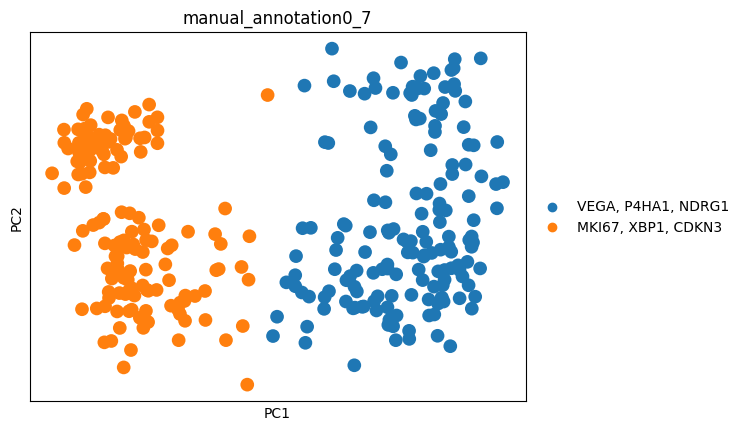

In [143]:
cluster_annotation0_7 = {
    "0": "VEGA, P4HA1, NDRG1",
    "1": "MKI67, XBP1, CDKN3"
}

adata.obs["manual_annotation0_7"] = adata.obs.leiden_res0_7.map(cluster_annotation0_7)

sc.pl.pca(adata, color=["manual_annotation0_7"])

These are our final results. Of course, we stress once again the fact that they are not unique, as they depend the library of marker genes we choose initially,nor optimal, as it might vary based on the dimensionality technique used, but rather serve as a tool to interpret the data and the results.

Now, the read should go to "MCF7_train".

In [144]:
# m_train = m_filtered.to_csv(path_or_buf = "/content/m_train.csv")